---
title: Atlas mapping for Redó-Riveiro et al. 2023
author: Martin Proks, Naz Salehin
date: 25-09-2023
---

#### Changelog
__25-09-2023__

Integration of the dataset without TE

__21-09-2023__

Analysis with STARsolo based quantification

In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rich import print


import warnings
# from lightning_fabric.plugins.environments.slurm import PossibleUserWarning
# warnings.simplefilter(action='ignore', category=PossibleUserWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
sc.settings.figdir = '../figures/'
sc.set_figure_params(dpi=120, dpi_save = 300, format='svg', transparent=True, figsize=(6,5))

sns.set_style("white")

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

# Analysis with TE

## Load in experimental single cell RNA-seq data

In [3]:
alba_adata = sc.read('../data/processed/10_dataset_v2.h5ad')

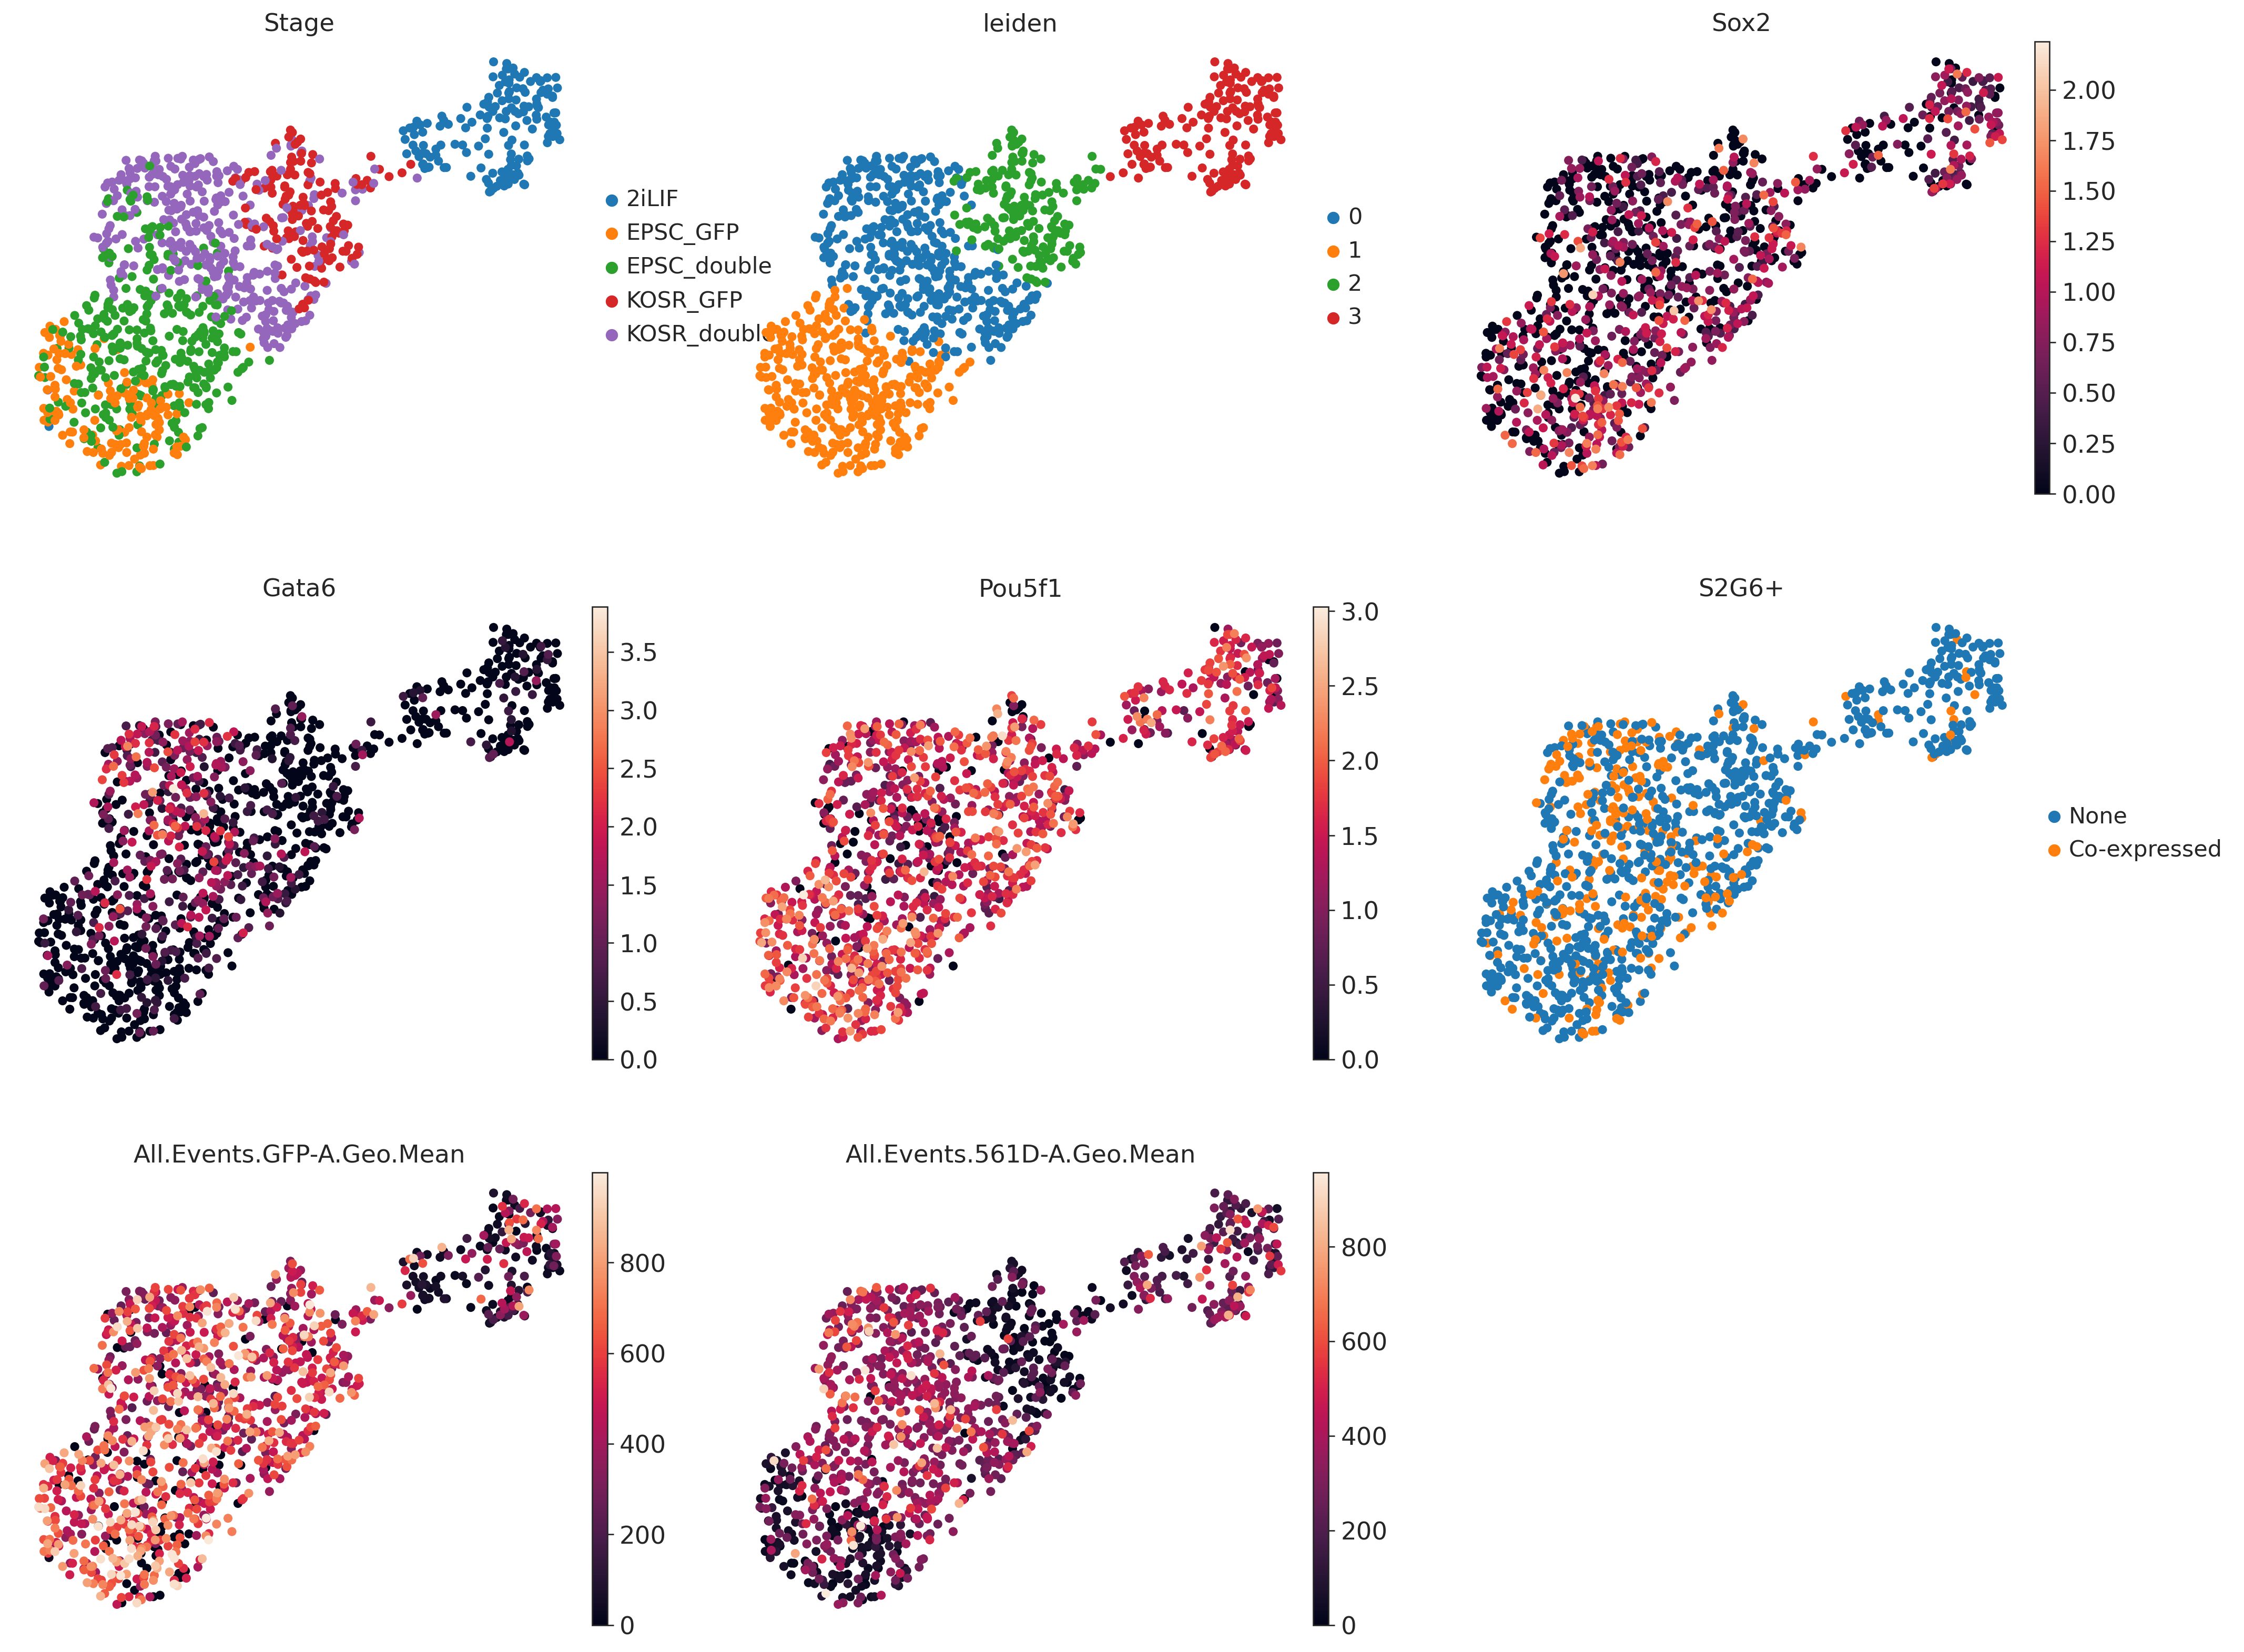

In [4]:
sc.pl.umap(alba_adata, color=['Stage', 'leiden', 'Sox2', 'Gata6', 'Pou5f1', 'S2G6+',
                         'All.Events.GFP-A.Geo.Mean', 'All.Events.561D-A.Geo.Mean'], ncols=3, frameon=False)

In [5]:
alba_adata

AnnData object with n_obs × n_vars = 1139 × 21590
    obs: 'Well_ID', 'Well_coordinates', 'plate_ID', 'Subject_ID', 'Amp_batch_ID', 'Cell_barcode', 'Pool_barcode', 'Batch', 'Condition', 'SampleName', 'Stage', 'Source', 'SubGroup', 'Group', 'Clone', 'All.Events.GFP-A.Geo.Mean', 'All.Events.561D-A.Geo.Mean', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts', 'leiden', 'S_score', 'G2M_score', 'phase', 'S2G6+'
    var: 'gene_ids', 'feature_types', 'mt', 'ercc', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'Amp_batch_ID_colors', 'S2G6+_colors', 'Stage_colors', 'dendrogram_Stage', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'plate_ID_colors', 'rank_genes_gr

## Load and preprocess the Nowotschin dataset

In [6]:
nowo = sc.read("../data/external/Nowotschin_et_al_2019/sc_endoderm_all_cells.h5ad")
meta = pd.read_csv("../data/external/Nowotschin_et_al_2019/e35_cell_types.csv", index_col=0)
nowo.obs.loc[meta.index, 'CellType'] = meta.CellType
nowo = nowo[
    nowo.obs.Timepoint.isin(['E3.5', 'E4.5'])
].copy()
nowo.obs['batch'] = "NOWO_1"
nowo.obs['experiment'] = "Nowotschin et al., 2019"
nowo.obs['technology'] = "10X 3' v2"
nowo.obs['ct'] = nowo.obs[['Timepoint', 'CellType']].agg('-'.join, axis=1)
nowo.obs['ct_orig'] = nowo.obs.CellType
nowo.obs = nowo.obs[['batch', 'experiment', 'technology', 'ct', 'ct_orig']]
nowo.var_names = nowo.var_names.str.lower()

sc.pp.filter_cells(nowo, min_counts=10)
sc.pp.filter_cells(nowo, min_genes=10)

nowo.layers["counts"] = nowo.X.copy()

sc.pp.normalize_total(nowo, target_sum=10_000)
sc.pp.log1p(nowo)
nowo.raw = nowo

In [7]:
sc.pp.highly_variable_genes(
    nowo,
    flavor="seurat_v3",
    n_top_genes=1_000,
    layer="counts",
    batch_key="batch",
    min_mean=0.0125, max_mean=10, min_disp=0.5,
    subset=True,
)

sc.pp.pca(nowo)
sc.pp.neighbors(nowo)
sc.tl.umap(nowo)

/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/projects/dan1/data/Brickman/conda/env

### Sanity plots for Nowotschin dataset

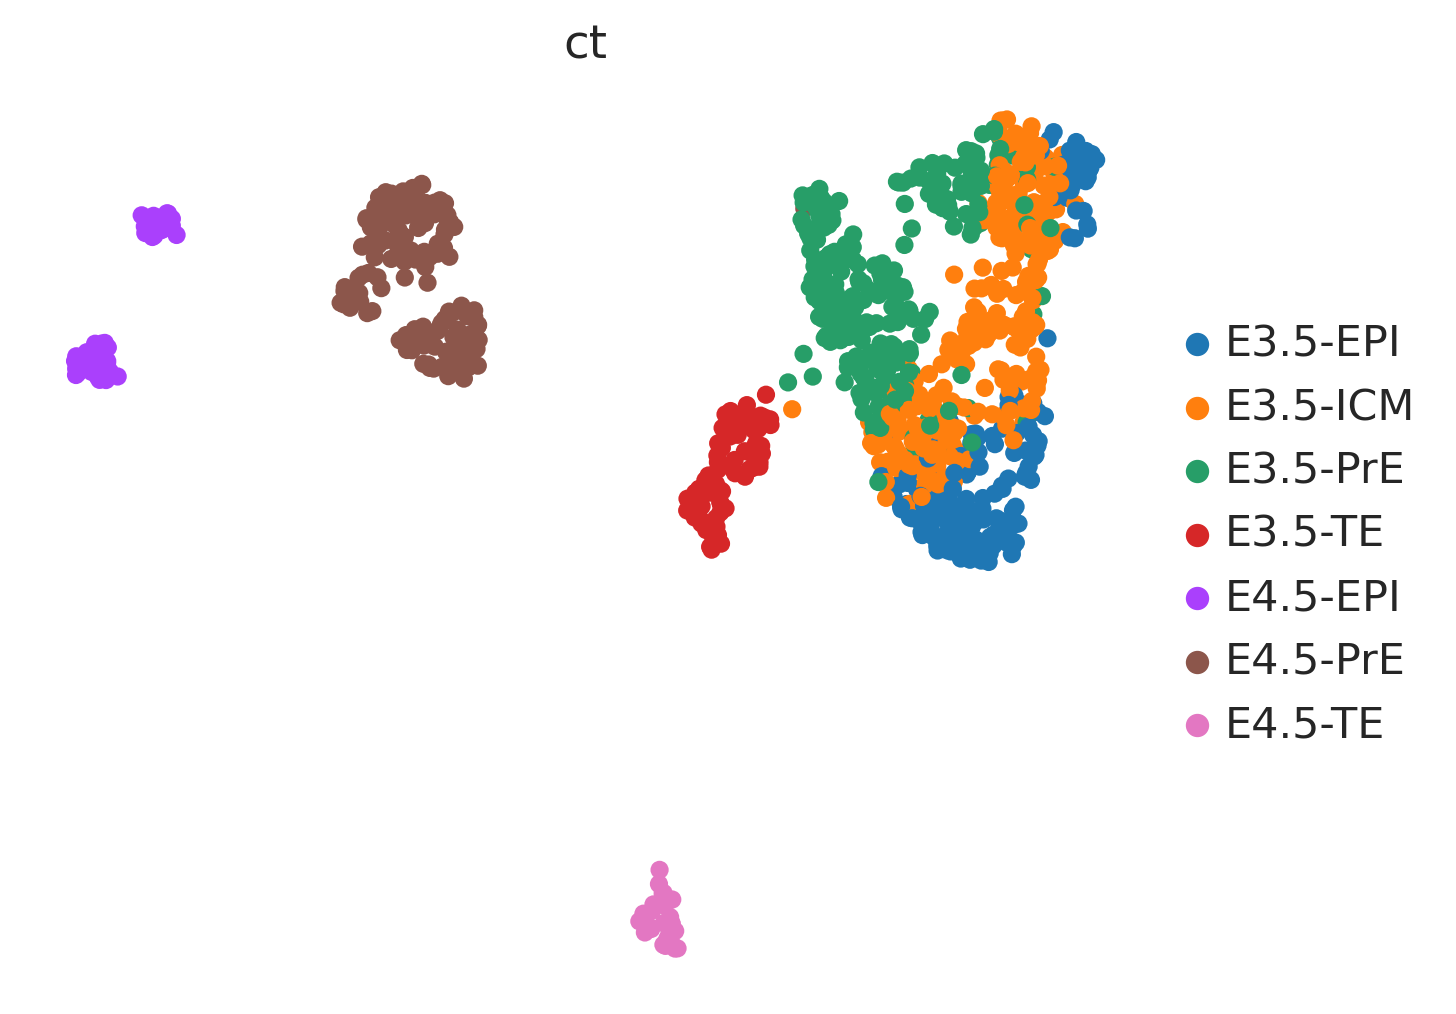

In [8]:
sc.pl.umap(
    nowo,
    color=["ct"],
    frameon=False,
    ncols=1,
    save="_integration_01_Nowotschin_only-with_TE-UMAP.svg"
)

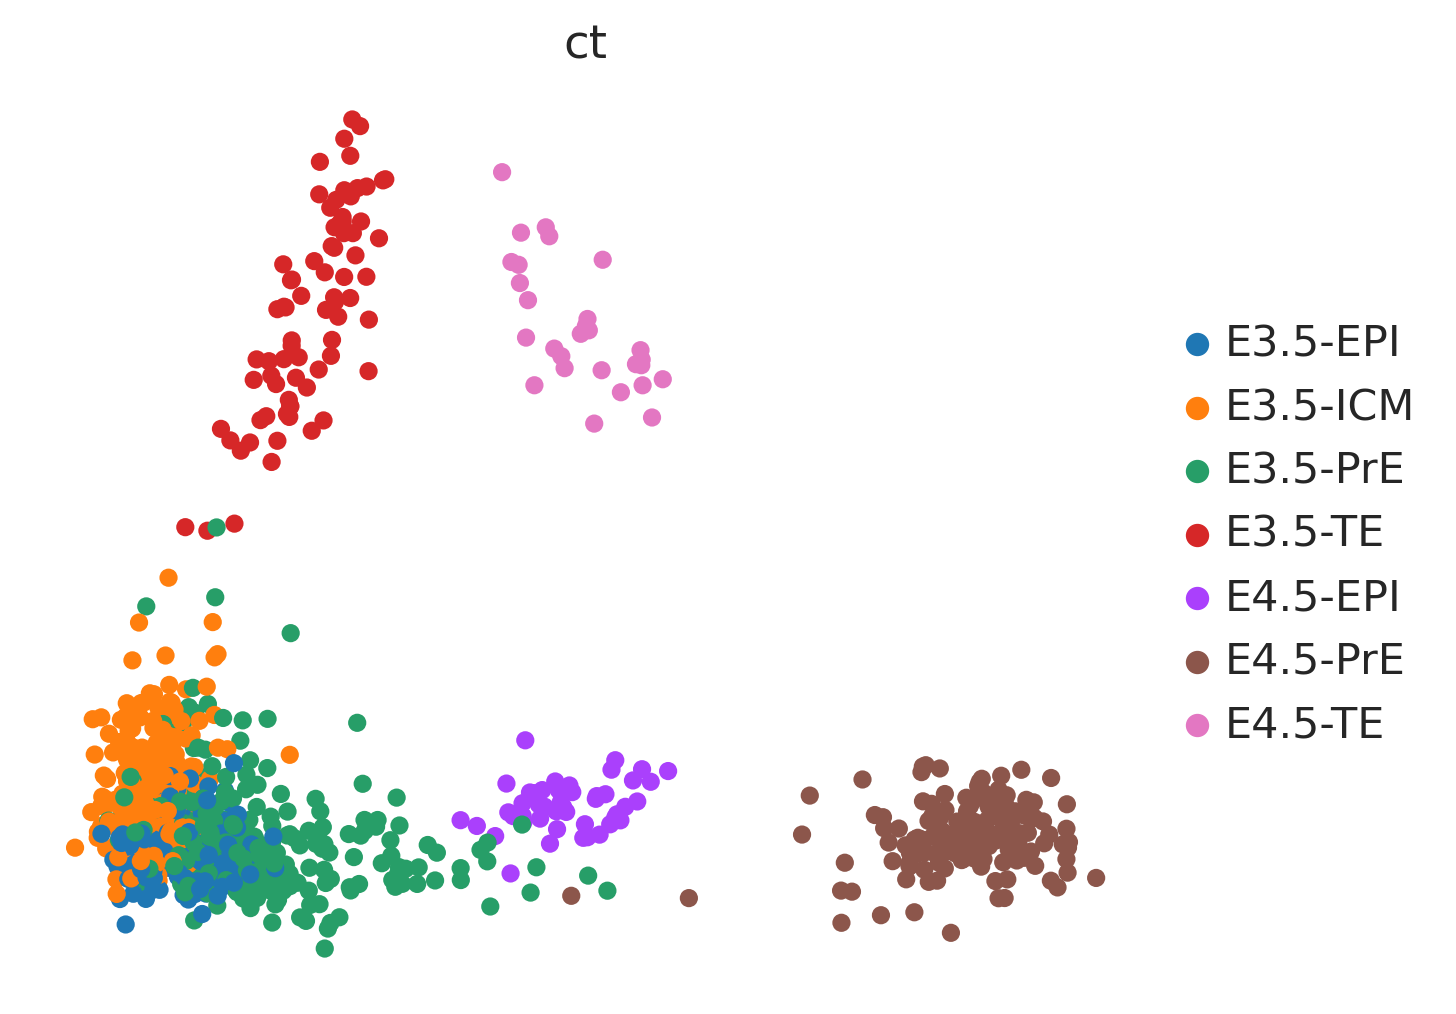

In [9]:
sc.pl.pca(
    nowo,
    color=["ct"],
    frameon=False,
    ncols=1,
    dimensions=[(0, 1)],
    save="_integration_02_Nowotschin_only-with_TE-PCA.svg"
)

In [10]:
nowo = nowo[:, nowo.var.highly_variable].copy()
sc.pp.scale(nowo, max_value=10)

### Map experimental dataset onto altas (Nowotschin) dataset

In [11]:
nowo.var_names = nowo.var_names.str.upper()
alba_adata.var_names = alba_adata.var_names.str.upper()
var_names = nowo.var_names.intersection(alba_adata.var_names)
nowo = nowo[:, var_names].copy()
alba_adata = alba_adata[:, var_names].copy()

In [12]:
sc.tl.ingest(alba_adata, nowo, obs = 'ct')

In [13]:
adata_concat = nowo.concatenate(alba_adata, batch_categories=['nowo', 'alba'])

In [14]:
adata_concat

AnnData object with n_obs × n_vars = 2145 × 919
    obs: 'batch', 'experiment', 'technology', 'ct', 'ct_orig', 'n_counts', 'n_genes', 'Well_ID', 'Well_coordinates', 'plate_ID', 'Subject_ID', 'Amp_batch_ID', 'Cell_barcode', 'Pool_barcode', 'Batch', 'Condition', 'SampleName', 'Stage', 'Source', 'SubGroup', 'Group', 'Clone', 'All.Events.GFP-A.Geo.Mean', 'All.Events.561D-A.Geo.Mean', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', 'total_counts_ribo', 'pct_counts_ribo', 'leiden', 'S_score', 'G2M_score', 'phase', 'S2G6+'
    var: 'highly_variable-alba', 'means-alba', 'highly_variable_nbatches-alba', 'mean-alba', 'std-alba', 'gene_ids-alba', 'feature_types-alba', 'mt-alba', 'ercc-alba', 'ribo-alba', 'n_cells_by_counts-alba', 'mean_counts-alba', 'pct_dropout_by_counts-alba', 'total_counts-alba', 'n_cells-alba', 'dispersions-alba', 'dispersions_norm-alba', 'highly_variable_intersection-alba', 'highly_variable-nowo', 'highly_varia

In [15]:
alba_annotated = adata_concat[adata_concat.obs.batch == 'alba']

In [16]:
alba_annotated

View of AnnData object with n_obs × n_vars = 1139 × 919
    obs: 'batch', 'experiment', 'technology', 'ct', 'ct_orig', 'n_counts', 'n_genes', 'Well_ID', 'Well_coordinates', 'plate_ID', 'Subject_ID', 'Amp_batch_ID', 'Cell_barcode', 'Pool_barcode', 'Batch', 'Condition', 'SampleName', 'Stage', 'Source', 'SubGroup', 'Group', 'Clone', 'All.Events.GFP-A.Geo.Mean', 'All.Events.561D-A.Geo.Mean', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', 'total_counts_ribo', 'pct_counts_ribo', 'leiden', 'S_score', 'G2M_score', 'phase', 'S2G6+'
    var: 'highly_variable-alba', 'means-alba', 'highly_variable_nbatches-alba', 'mean-alba', 'std-alba', 'gene_ids-alba', 'feature_types-alba', 'mt-alba', 'ercc-alba', 'ribo-alba', 'n_cells_by_counts-alba', 'mean_counts-alba', 'pct_dropout_by_counts-alba', 'total_counts-alba', 'n_cells-alba', 'dispersions-alba', 'dispersions_norm-alba', 'highly_variable_intersection-alba', 'highly_variable-nowo', 'high

In [17]:
pd.crosstab(alba_annotated.obs.Stage, alba_annotated.obs.ct)

ct           E3.5-EPI  E3.5-ICM  E3.5-PrE  E3.5-TE  E4.5-EPI  E4.5-PrE  \
Stage                                                                    
2iLIF              90        12        45       10         2         1   
EPSC_GFP           90         5        47        0         0         0   
EPSC_double        87        64       173        2         0         1   
KOSR_GFP           62         7        63        2         2         0   
KOSR_double        75        55       232        7         1         0   

ct           E4.5-TE  
Stage                 
2iLIF              3  
EPSC_GFP           0  
EPSC_double        0  
KOSR_GFP           1  
KOSR_double        0

In [18]:
pd.crosstab(alba_adata.obs.Stage, alba_adata.obs.leiden)

leiden         0    1    2    3
Stage                          
2iLIF          0    1    0  162
EPSC_GFP       1  141    0    0
EPSC_double  114  213    0    0
KOSR_GFP       6    0  128    3
KOSR_double  310    3   56    1

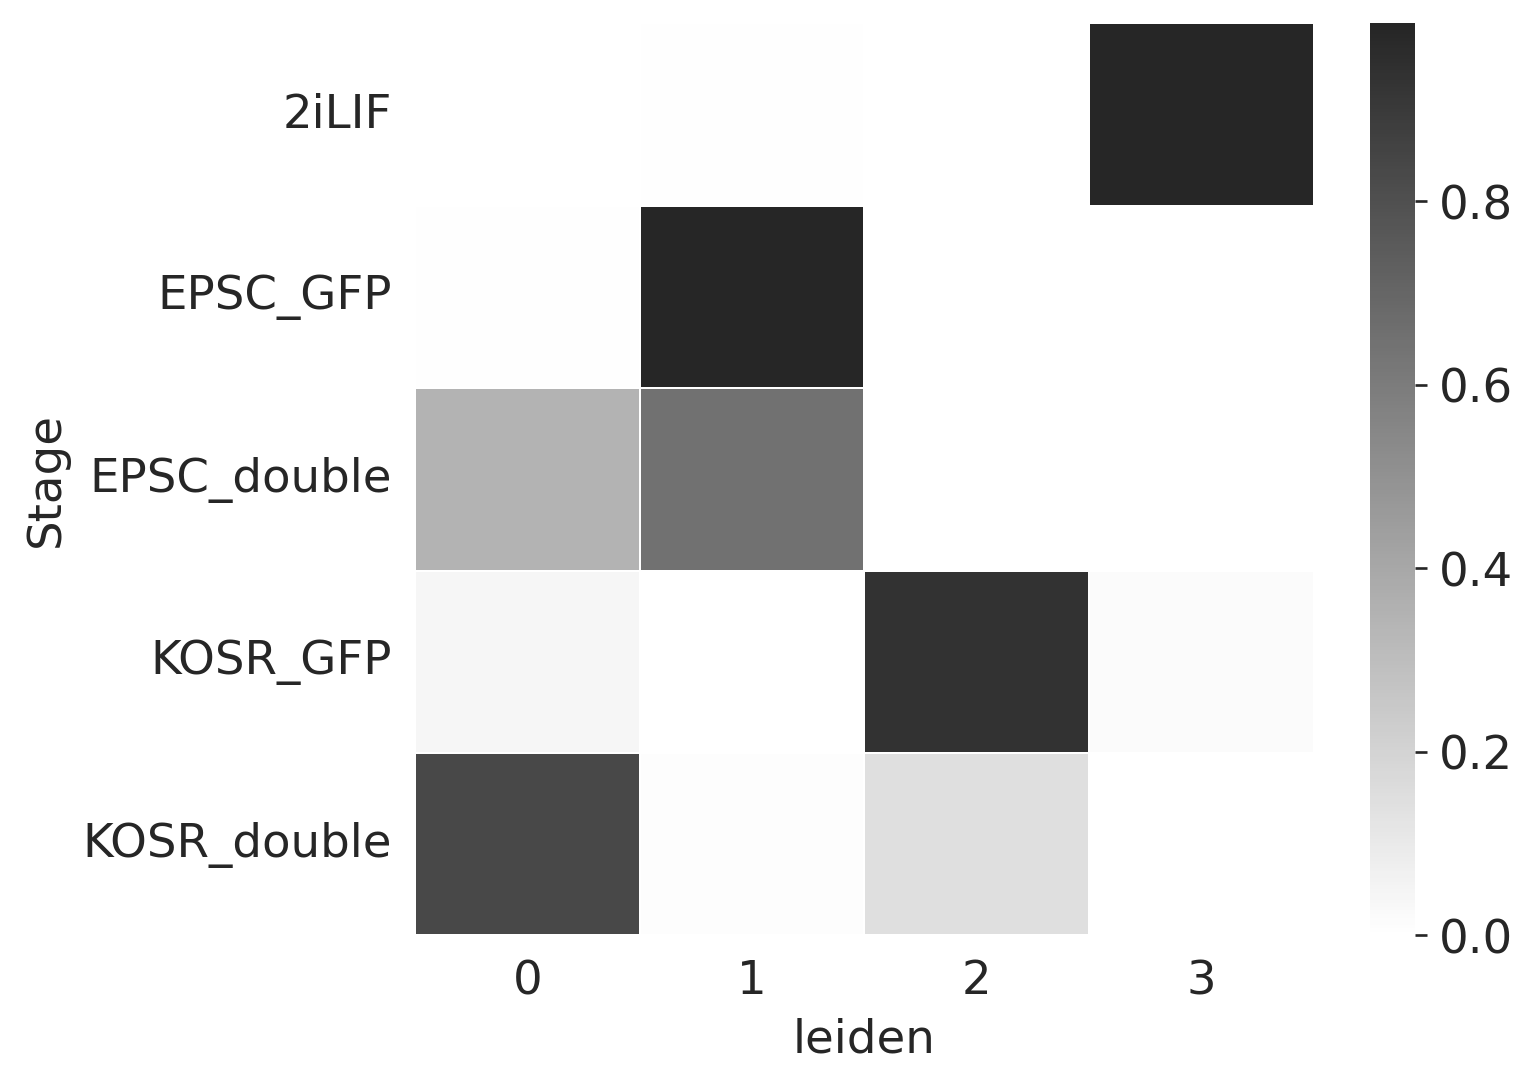

In [19]:
ax = sns.heatmap(sc.metrics.confusion_matrix("Stage", "leiden", alba_annotated.obs), cmap=sns.dark_palette("white", reverse=True, as_cmap=True),linewidth=.5)
fig = ax.get_figure()
fig.savefig(f'{sc.settings.figdir}/crosstab_01_Stage_vs_Leiden_cluster.svg')

In [20]:
alba_annotated.obs.Stage.value_counts()

KOSR_double    370
EPSC_double    327
2iLIF          163
EPSC_GFP       142
KOSR_GFP       137
Name: Stage, dtype: int64

In [21]:
alba_annotated_df=pd.DataFrame({
    'condition':alba_annotated.obs.Stage,
    'annotation':alba_annotated.obs.ct,
})

In [22]:
proportions_df = pd.crosstab(alba_annotated.obs.Stage,alba_annotated.obs.ct, normalize='index')

In [23]:
proportions_df_notNorm = pd.crosstab(alba_annotated.obs.Stage,alba_annotated.obs.ct)

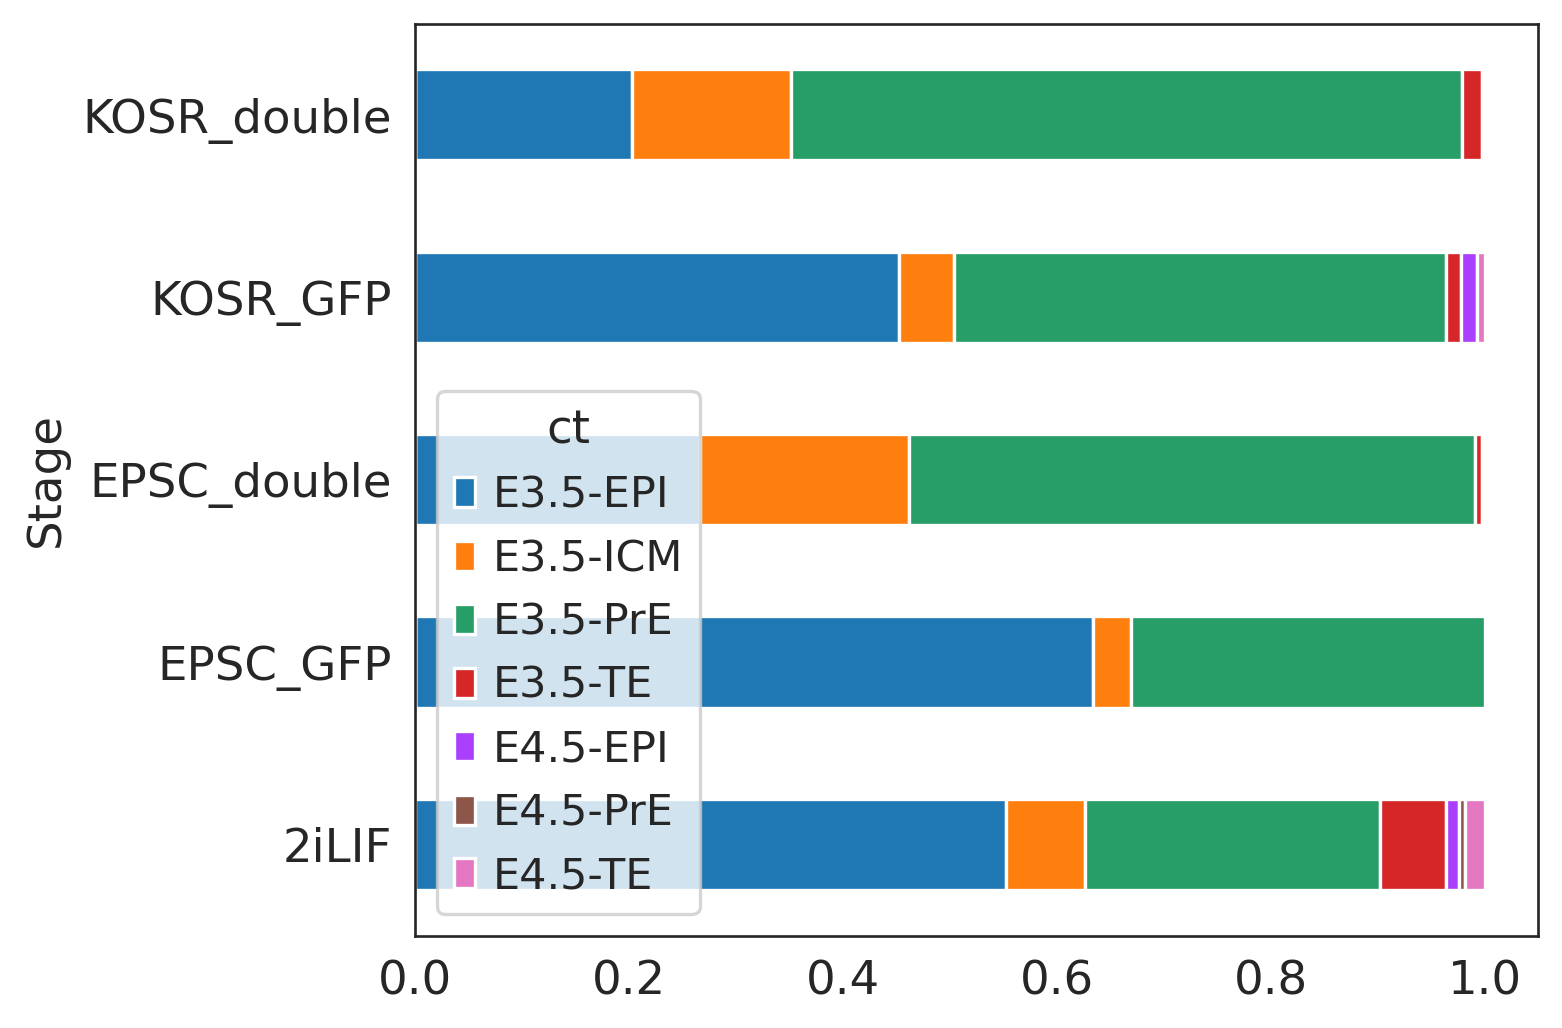

In [24]:
ax = proportions_df.plot.barh(
    stacked=True,
    grid=False,
    )
fig = ax.get_figure()
fig.savefig(f'{sc.settings.figdir}/integration_03_CellProportions_Integrated_with-TE.svg')

In [25]:
proportions_of_clusters_df = pd.crosstab(alba_annotated.obs.leiden, alba_annotated.obs.ct, normalize='index')
proportions_of_clusters_df_notNorm = pd.crosstab(alba_annotated.obs.leiden, alba_annotated.obs.ct)

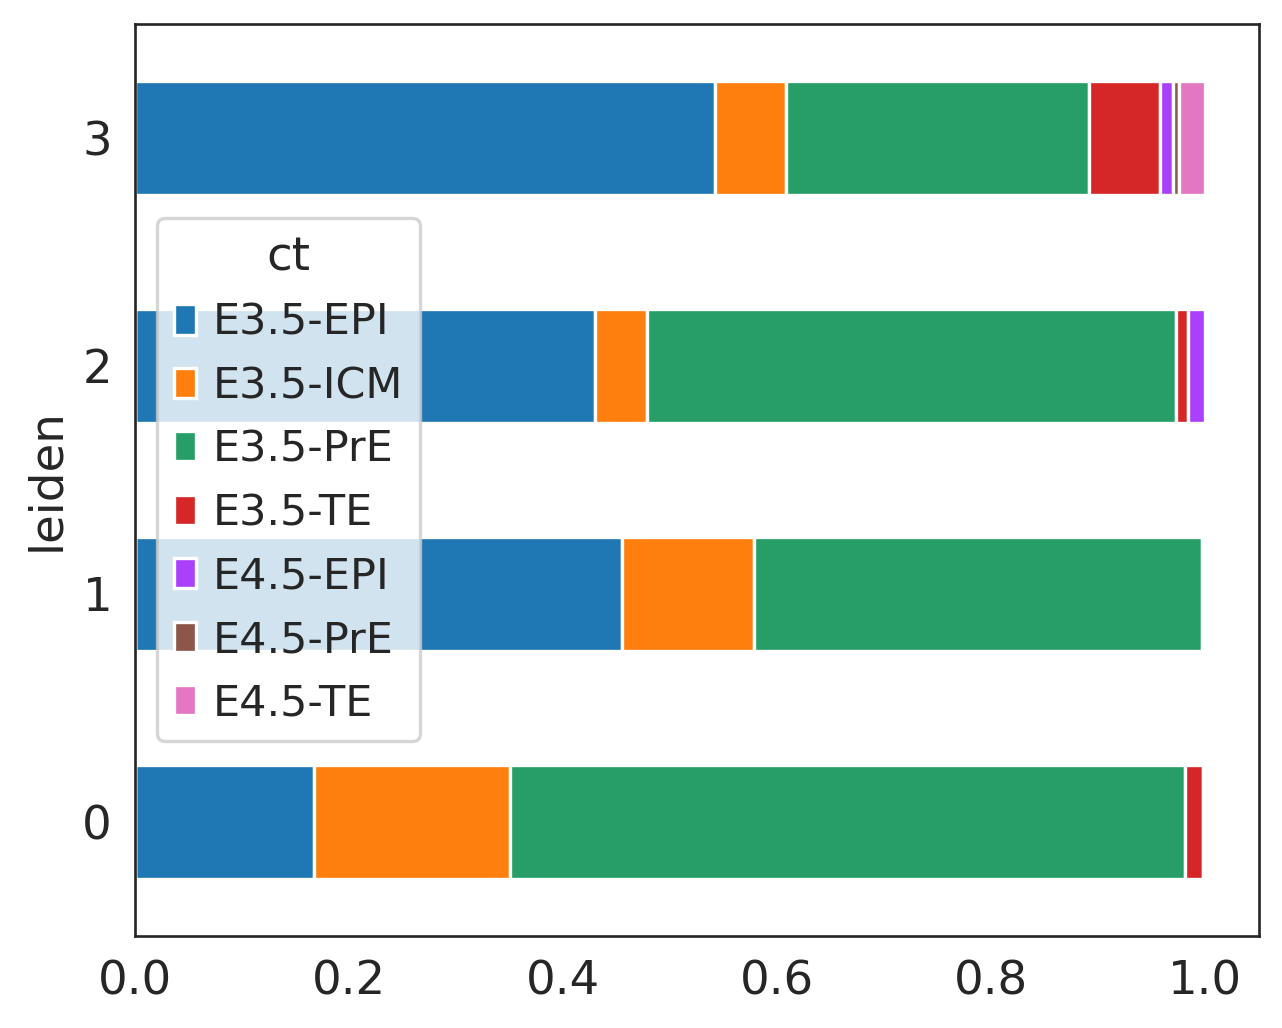

In [26]:
ax = proportions_of_clusters_df.plot.barh(
    stacked=True,
    grid=False,
    )
fig = ax.get_figure()
fig.savefig(f'{sc.settings.figdir}/integration_04_CellProportionsLeidenClusters_Integrated_with-TE.svg')

## Contingency table analysis

In [27]:
import scipy.stats as stats

In [28]:
stats.chi2_contingency(proportions_df_notNorm)

Chi2ContingencyResult(statistic=201.78632492668822, pvalue=4.715612624607903e-30, dof=24, expected_freq=array([[ 57.81562774,  20.46444249,  80.1404741 ,   3.00526778,
          0.71553995,   0.28621598,   0.57243196],
       [ 50.36698859,  17.82791923,  69.81562774,   2.61808604,
          0.62335382,   0.24934153,   0.49868306],
       [115.98595259,  41.05443371, 160.77260755,   6.02897278,
          1.43546971,   0.57418788,   1.14837577],
       [ 48.59350307,  17.20017559,  67.35733099,   2.52589991,
          0.60140474,   0.2405619 ,   0.48112379],
       [131.23792801,  46.45302897, 181.91395961,   6.82177349,
          1.62423178,   0.64969271,   1.29938543]]))

In [29]:
alba_chi2 = stats.chi2_contingency(proportions_df_notNorm)

In [30]:
alba_chi2

Chi2ContingencyResult(statistic=201.78632492668822, pvalue=4.715612624607903e-30, dof=24, expected_freq=array([[ 57.81562774,  20.46444249,  80.1404741 ,   3.00526778,
          0.71553995,   0.28621598,   0.57243196],
       [ 50.36698859,  17.82791923,  69.81562774,   2.61808604,
          0.62335382,   0.24934153,   0.49868306],
       [115.98595259,  41.05443371, 160.77260755,   6.02897278,
          1.43546971,   0.57418788,   1.14837577],
       [ 48.59350307,  17.20017559,  67.35733099,   2.52589991,
          0.60140474,   0.2405619 ,   0.48112379],
       [131.23792801,  46.45302897, 181.91395961,   6.82177349,
          1.62423178,   0.64969271,   1.29938543]]))

In [31]:
alba_chi2.pvalue

4.715612624607903e-30

In [32]:
alba_chi2.statistic

201.78632492668822

In [33]:
# https://stackoverflow.com/questions/20453729/what-is-the-equivalent-of-r-data-chisqresiduals-in-python
from scipy.stats.contingency import margins

def residuals(observed, expected):
    return (observed - expected) / np.sqrt(expected)

def stdres(observed, expected):
    n = observed.sum()
    rsum, csum = margins(observed)
    # With integers, the calculation
    #     csum * rsum * (n - rsum) * (n - csum)
    # might overflow, so convert rsum and csum to floating point.
    rsum = rsum.astype(np.float64)
    csum = csum.astype(np.float64)
    v = csum * rsum * (n - rsum) * (n - csum) / n**3
    return (observed - expected) / np.sqrt(v)

In [34]:
sns.set_style("dark")

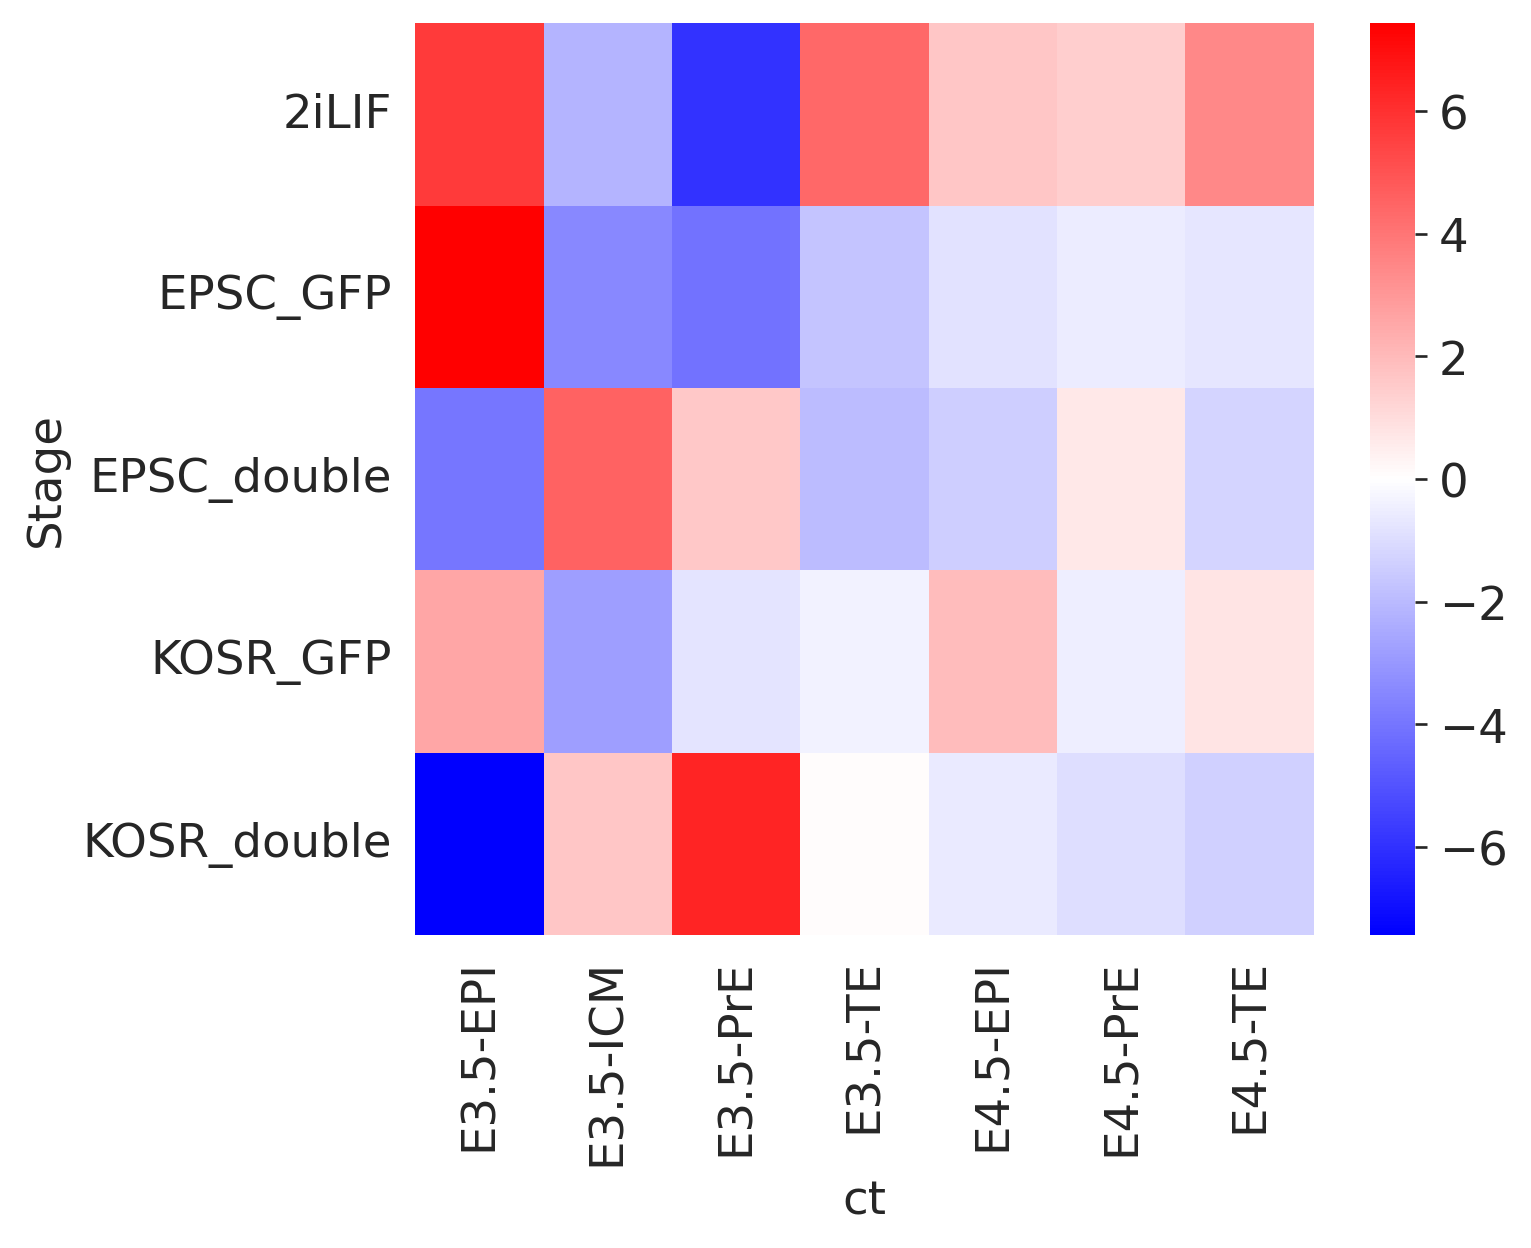

In [35]:
ax = sns.heatmap(
    pd.DataFrame(stdres(proportions_df_notNorm.to_numpy(), alba_chi2.expected_freq), columns= proportions_df_notNorm.columns, index=proportions_df_notNorm.index),
    cmap='bwr'
)
fig = ax.get_figure()
fig.savefig(f'{sc.settings.figdir}/integration_05_ChiSquared_NormalisedResiduals-withTE.svg')

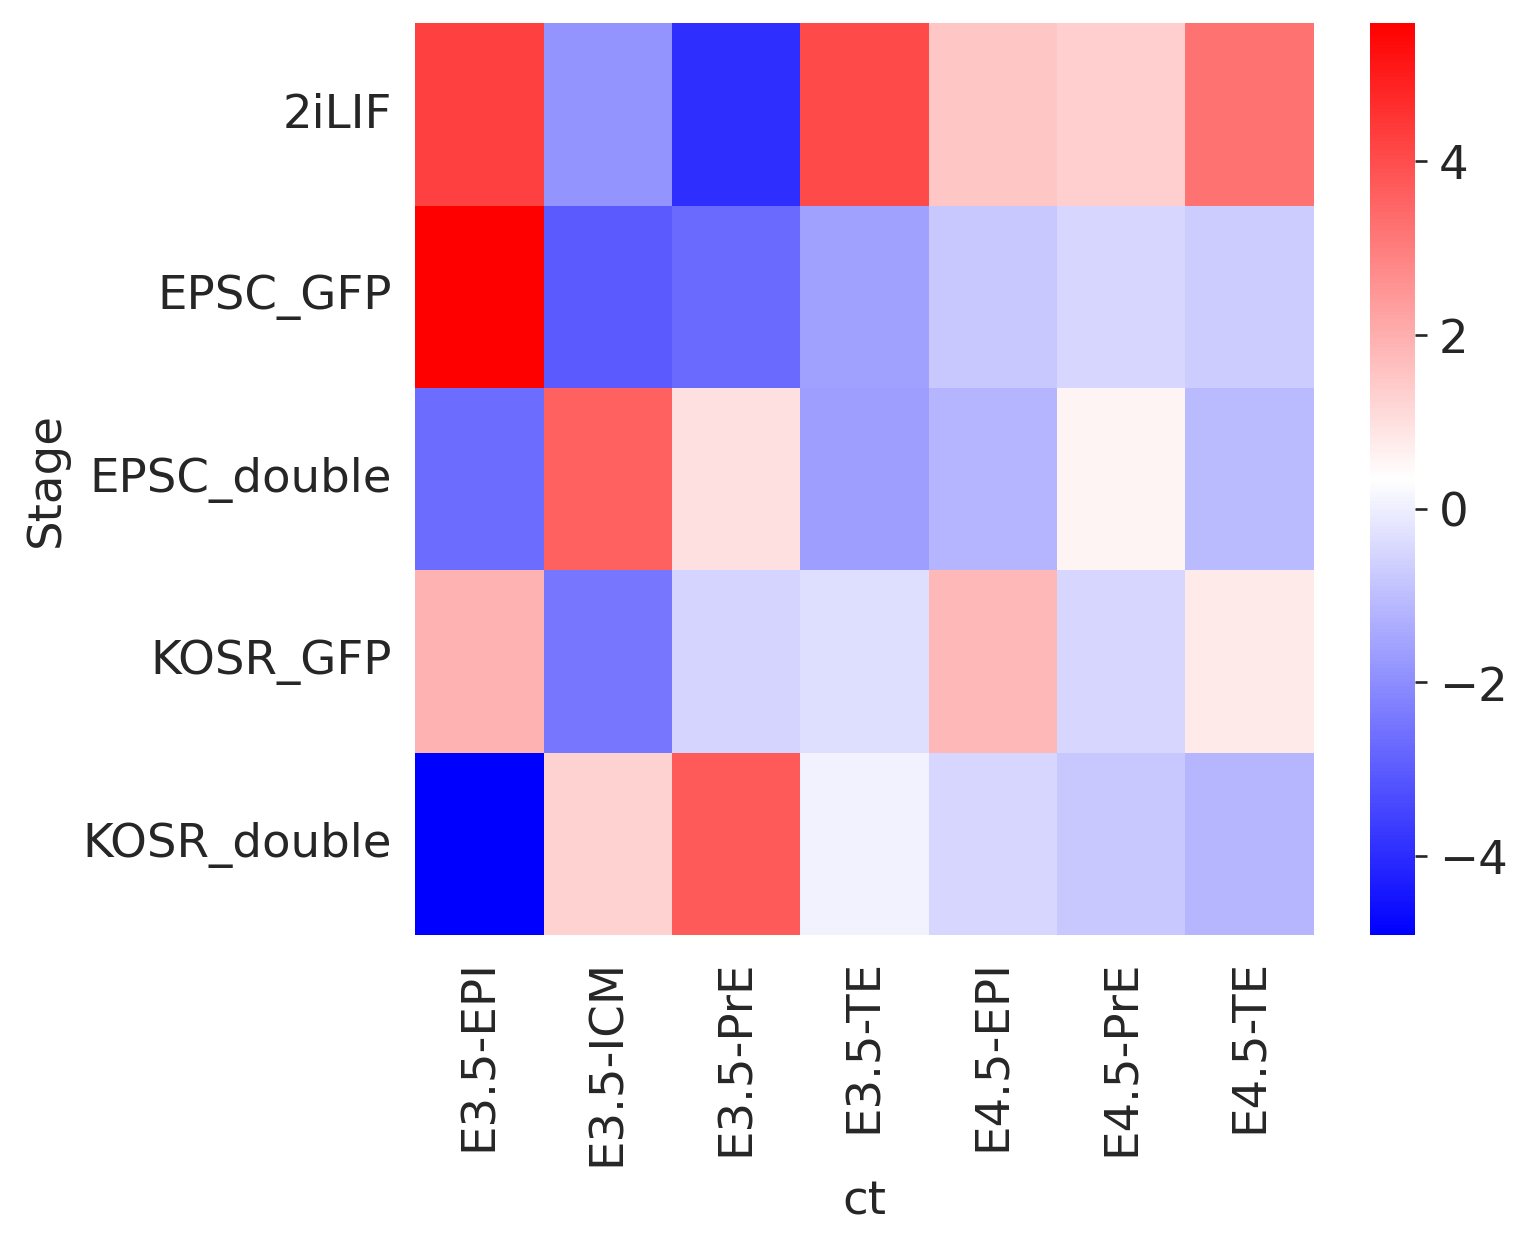

In [36]:
ax = sns.heatmap(
    pd.DataFrame(residuals(proportions_df_notNorm.to_numpy(), alba_chi2.expected_freq), columns= proportions_df_notNorm.columns, index=proportions_df_notNorm.index),
    cmap='bwr'
)
fig = ax.get_figure()
fig.savefig(f'{sc.settings.figdir}/integration_06_ChiSquared_RawResiduals-withTE.svg')

### Significance tests using clusters

In [37]:
stats.chi2_contingency(proportions_of_clusters_df_notNorm)

Chi2ContingencyResult(statistic=196.4951224929756, pvalue=5.025159340654328e-32, dof=18, expected_freq=array([[152.87445127,  54.11150132, 211.90517998,   7.94644425,
          1.89201054,   0.75680421,   1.51360843],
       [126.98156277,  44.94644425, 176.01404741,   6.60052678,
          1.57155399,   0.6286216 ,   1.2572432 ],
       [ 65.2642669 ,  23.10096576,  90.46532046,   3.39244952,
          0.80772608,   0.32309043,   0.64618086],
       [ 58.87971905,  20.84108867,  81.61545215,   3.06057946,
          0.72870939,   0.29148376,   0.58296752]]))

In [38]:
seurat_clusters_chi2 = stats.chi2_contingency(proportions_of_clusters_df_notNorm)

In [39]:
seurat_clusters_chi2.pvalue

5.025159340654328e-32

In [40]:
seurat_clusters_chi2.statistic

196.4951224929756

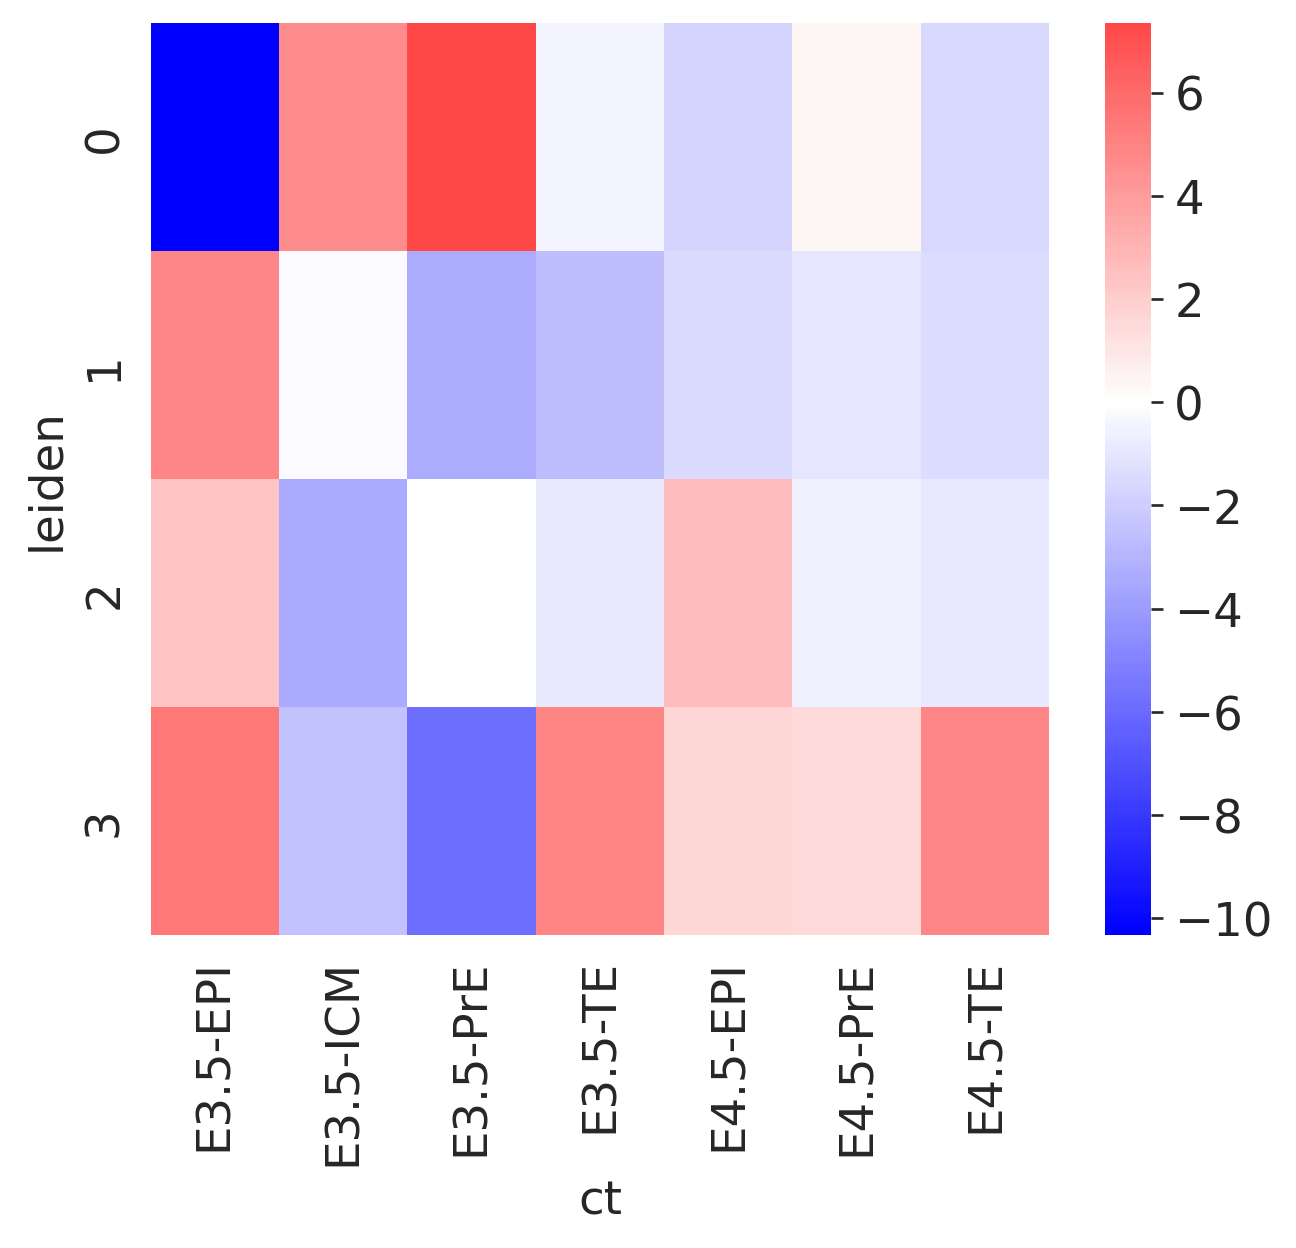

In [41]:
ax = sns.heatmap(
    pd.DataFrame(stdres(proportions_of_clusters_df_notNorm.to_numpy(), seurat_clusters_chi2.expected_freq), columns= proportions_of_clusters_df_notNorm.columns, index=proportions_of_clusters_df_notNorm.index),
    cmap='bwr', center = 0.0
)
fig = ax.get_figure()
fig.savefig(f'{sc.settings.figdir}/integration_07_LeidenClusters_ChiSquared_NormalisedResiduals-withTE.svg')

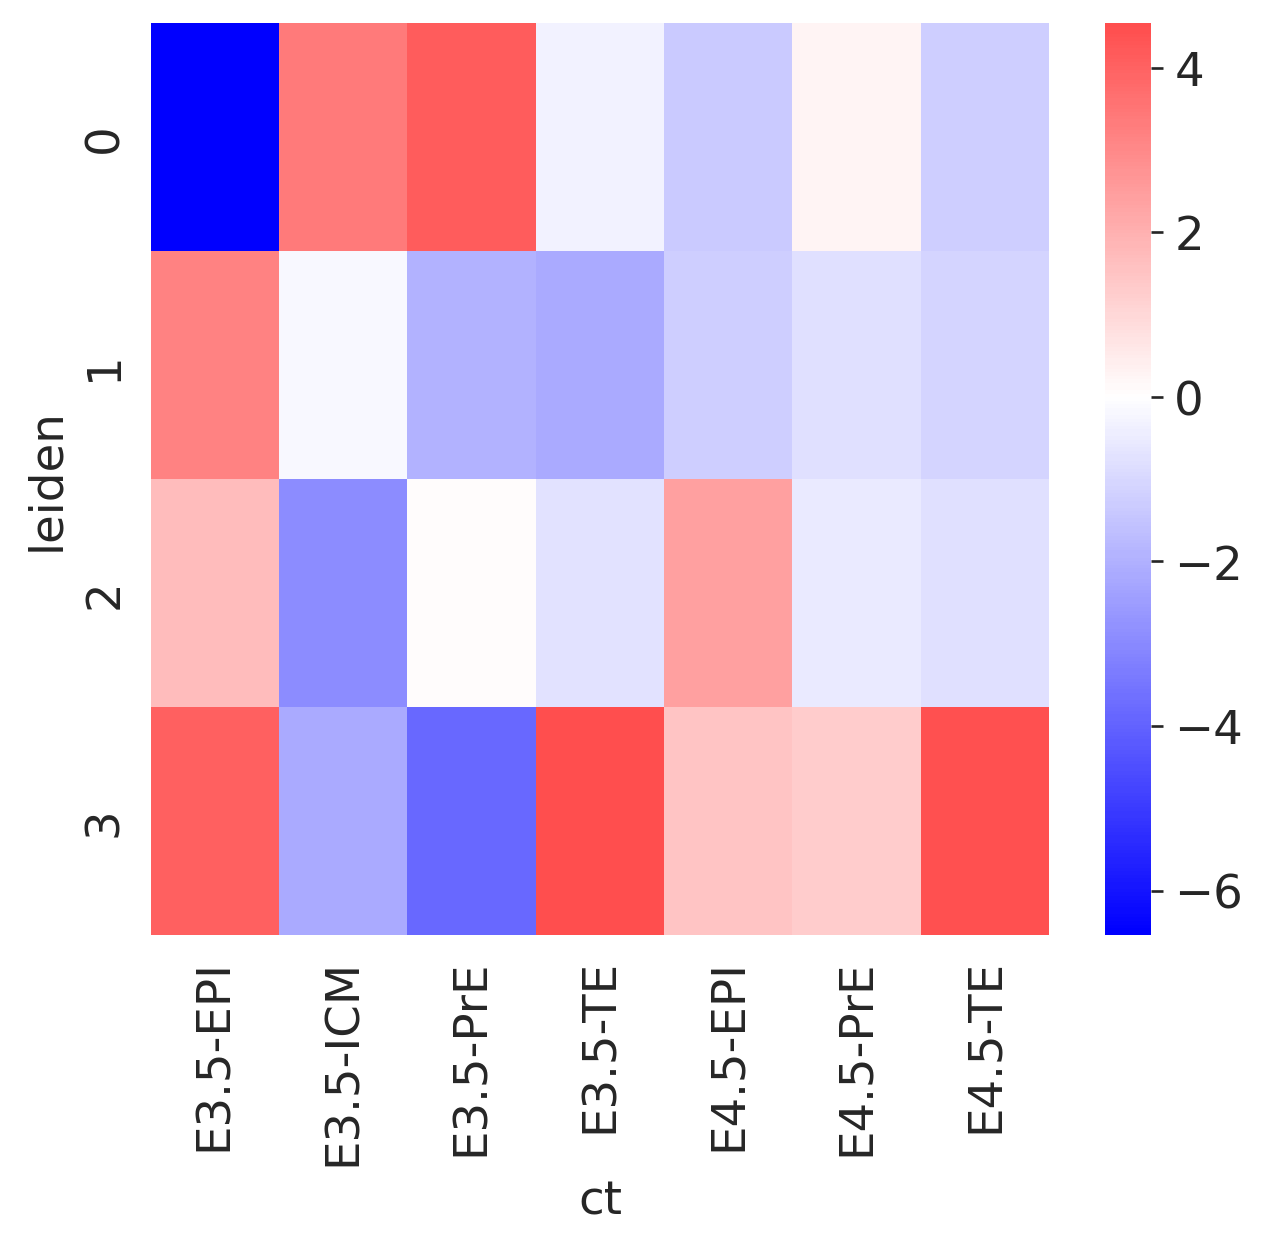

In [42]:
ax = sns.heatmap(
    pd.DataFrame(residuals(proportions_of_clusters_df_notNorm.to_numpy(), seurat_clusters_chi2.expected_freq), columns= proportions_of_clusters_df_notNorm.columns, index=proportions_of_clusters_df_notNorm.index),
    cmap='bwr', center = 0.0
)
fig = ax.get_figure()
fig.savefig(f'{sc.settings.figdir}/integration_08_LeidenClusters_ChiSquared_RawResiduals-withTE.svg')

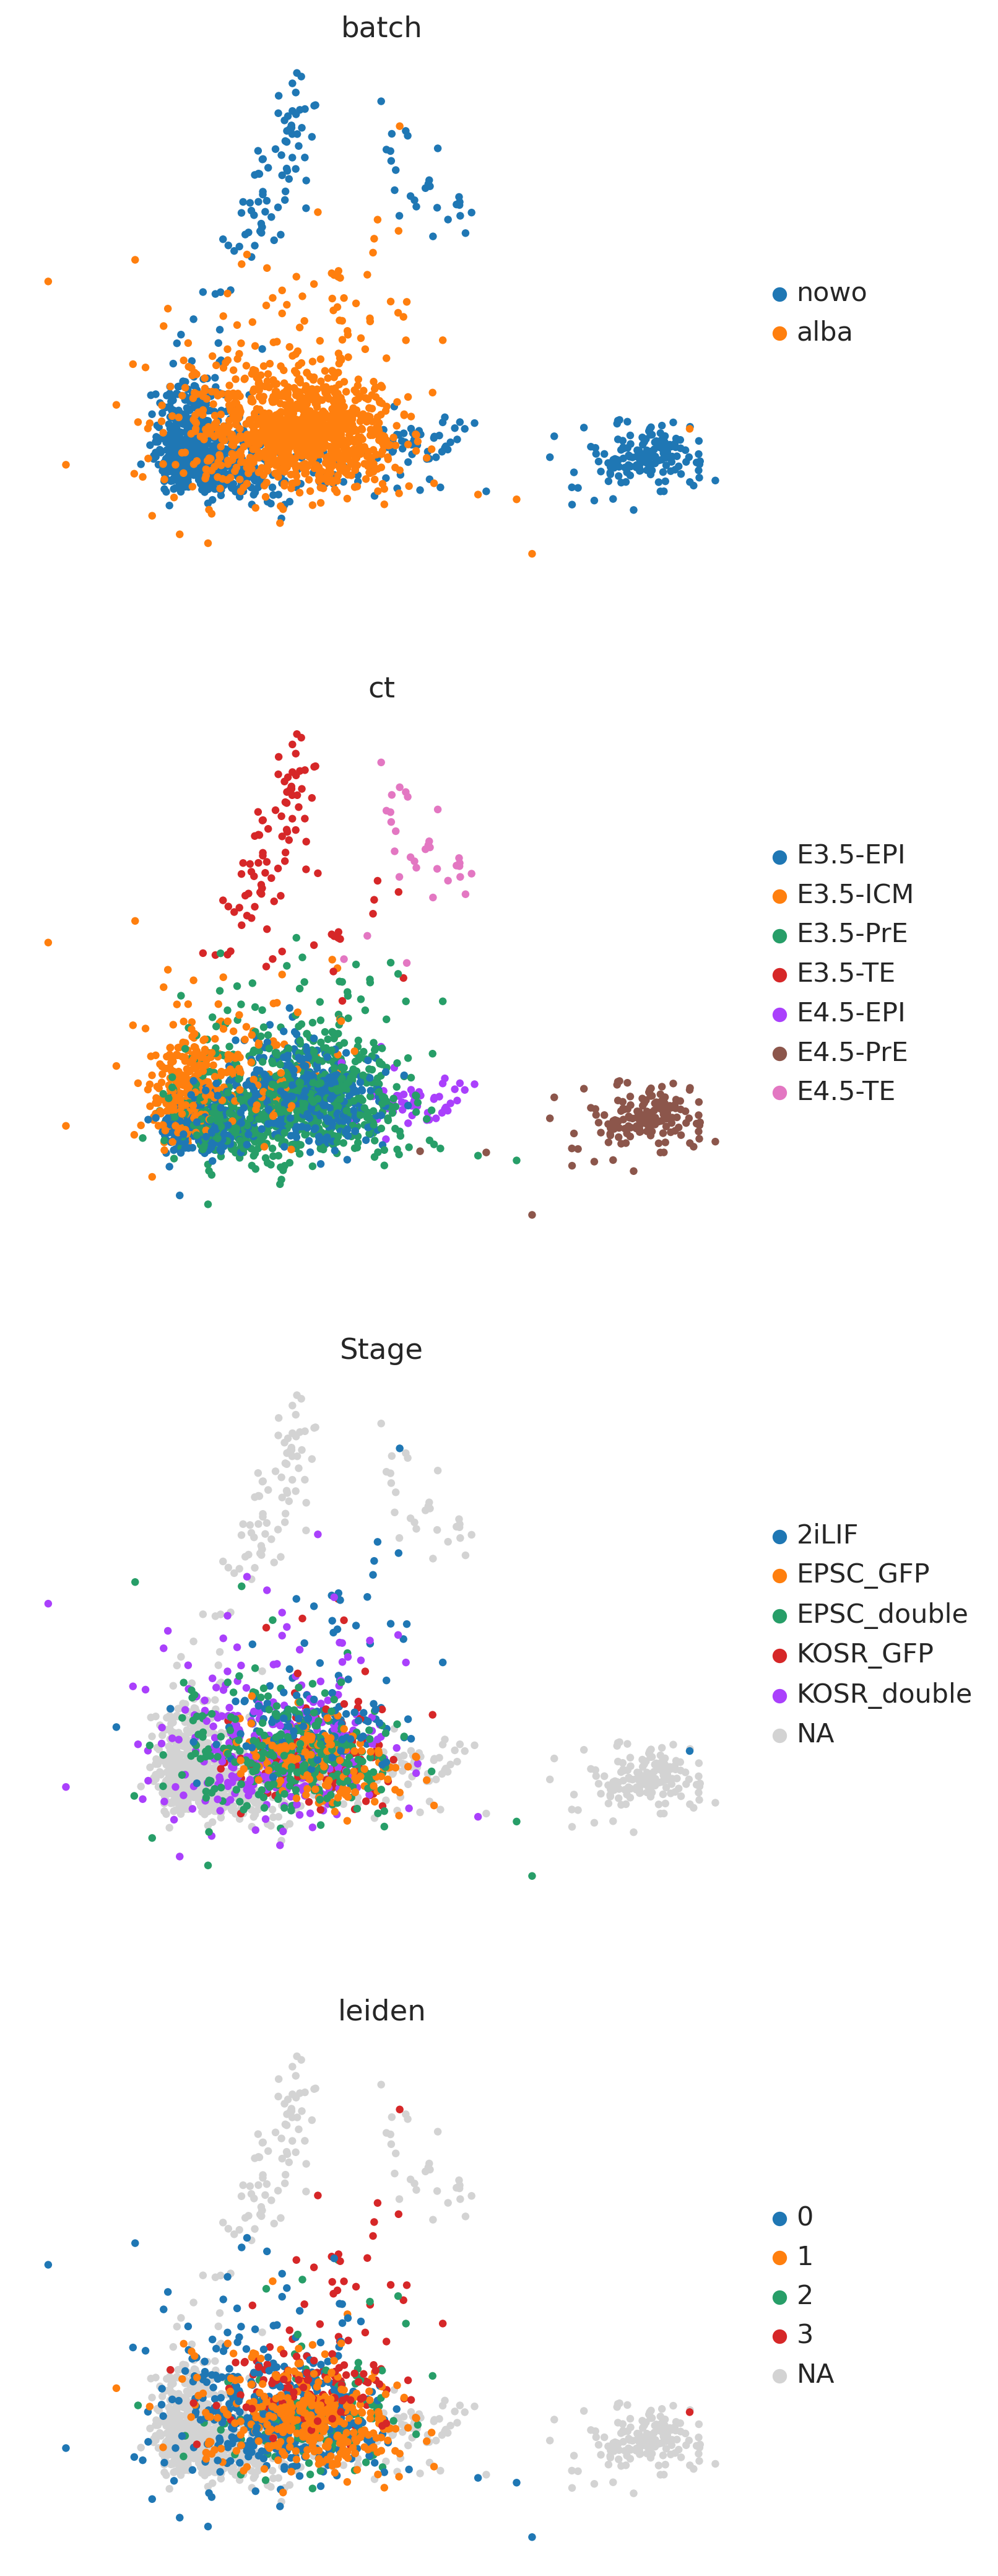

In [43]:
sc.pl.pca(adata_concat,
    color=['batch', 'ct', 'Stage', 'leiden'],
    frameon=False,
    ncols=1,)

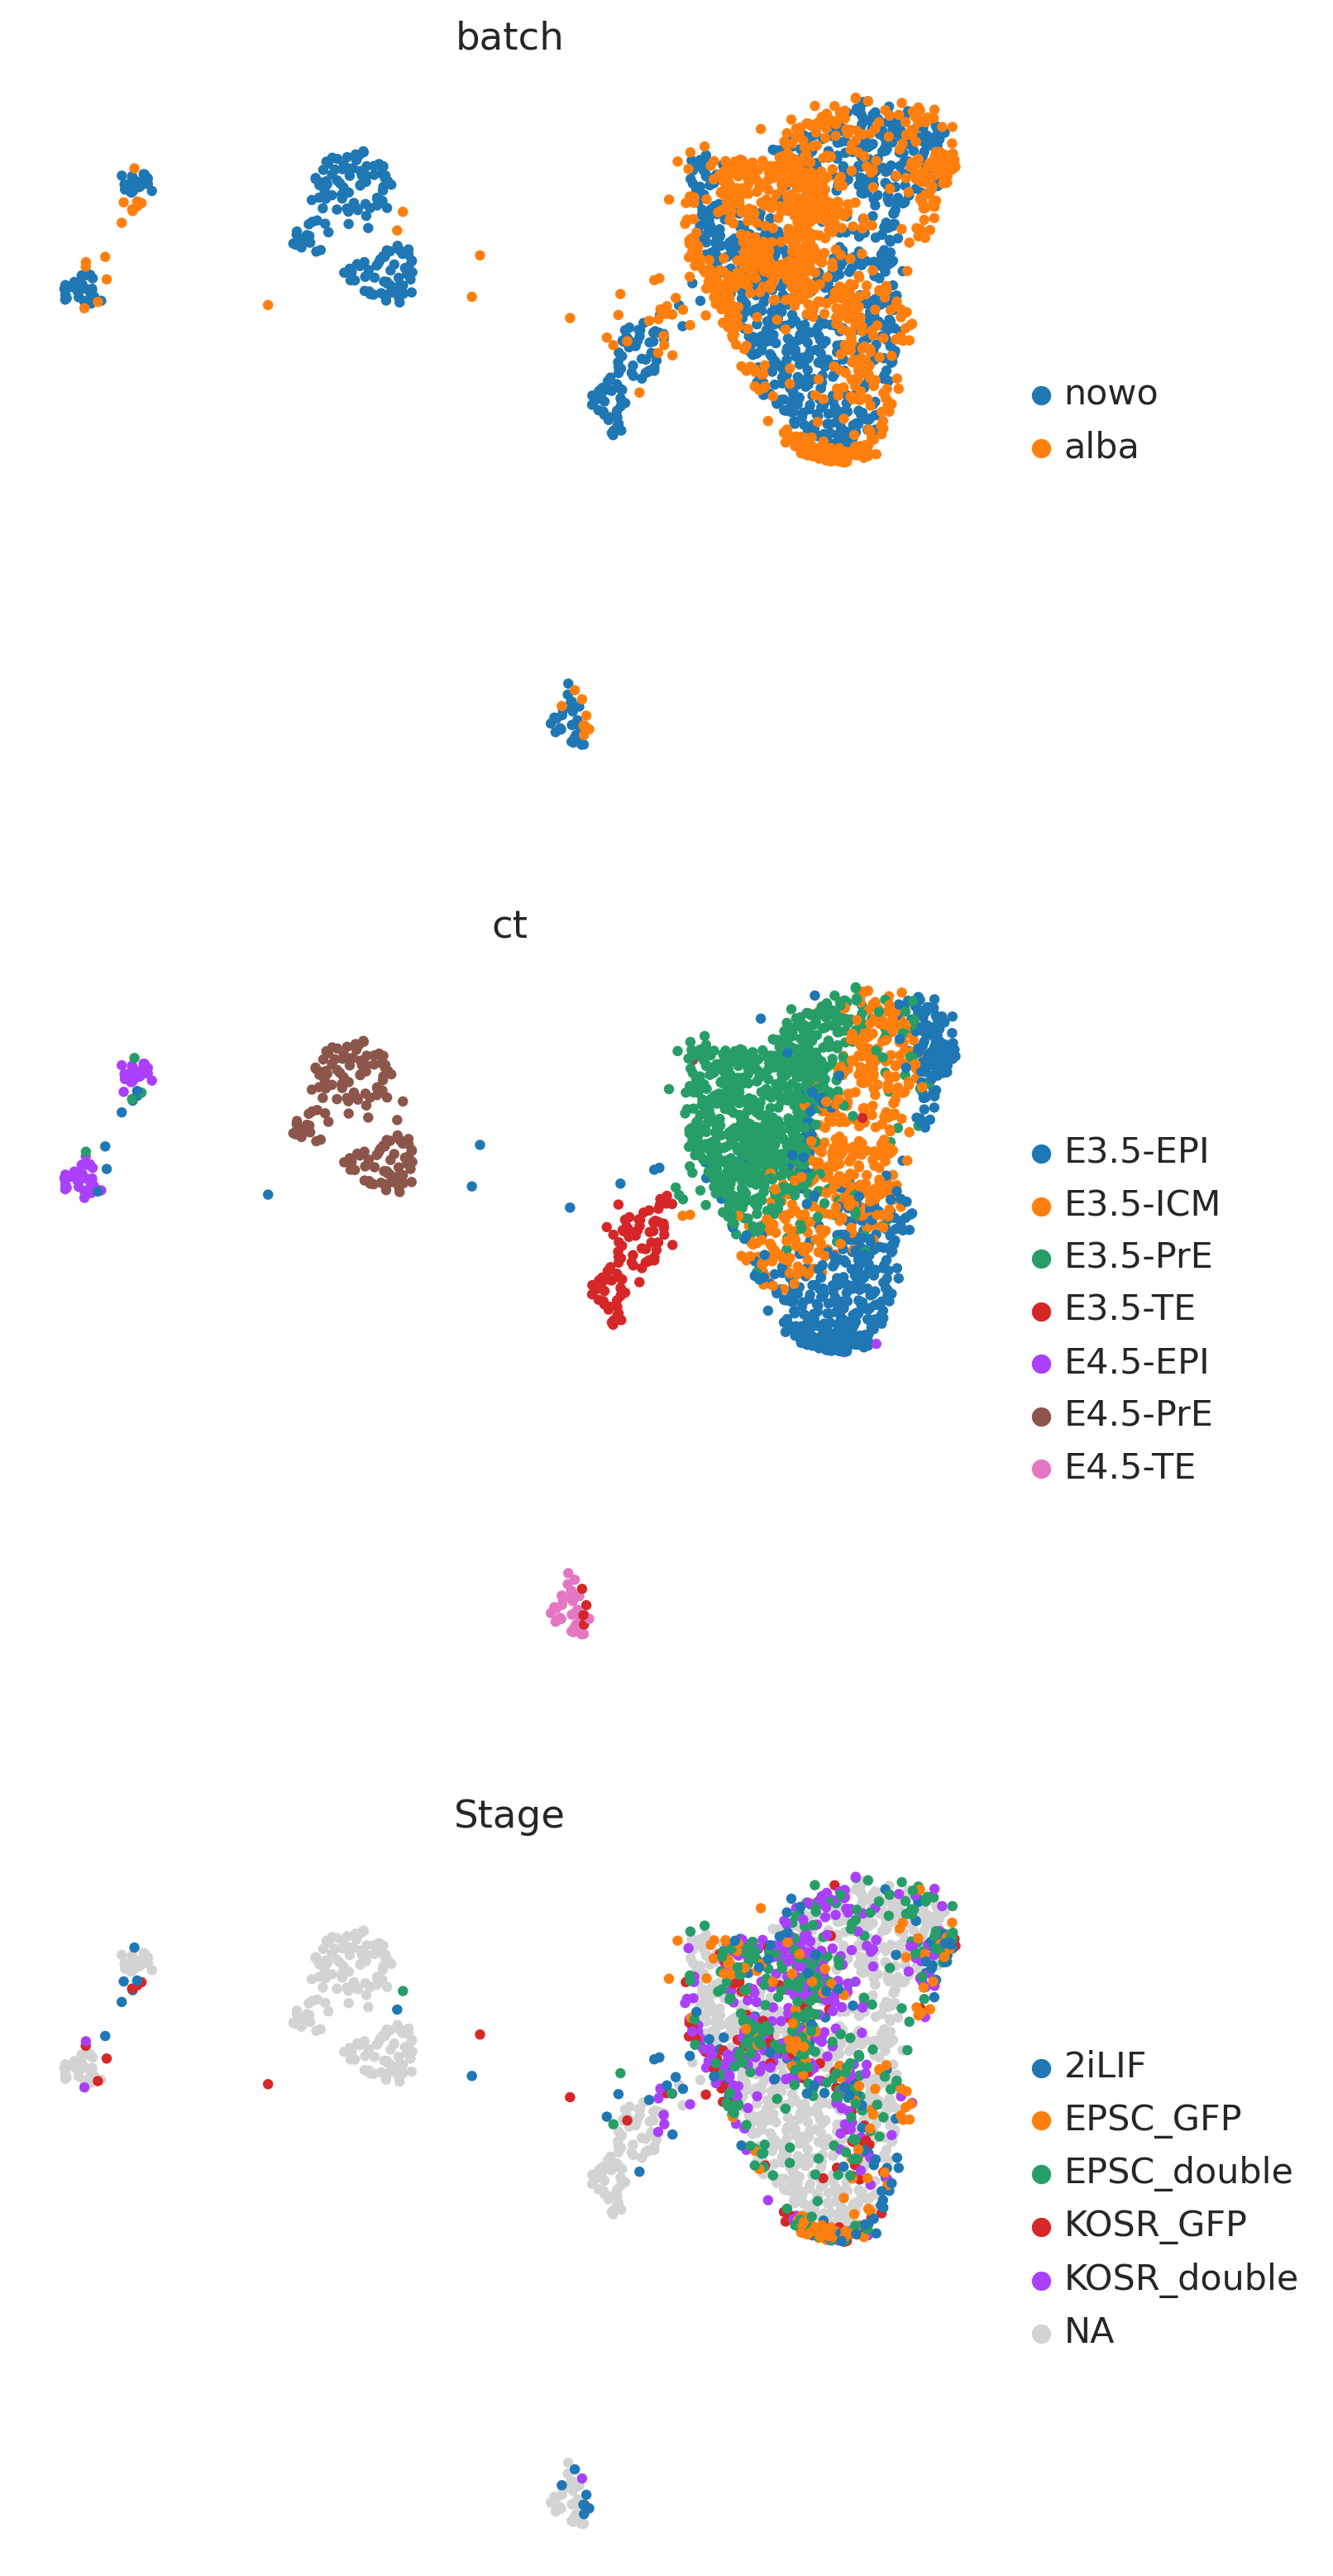

In [44]:
sc.pl.umap(adata_concat,
    color=['batch', 'ct', 'Stage'],
    ncols = 1,
    frameon=False,
    save="_integration_09_UMAP_integrated_withTE.svg",
 )

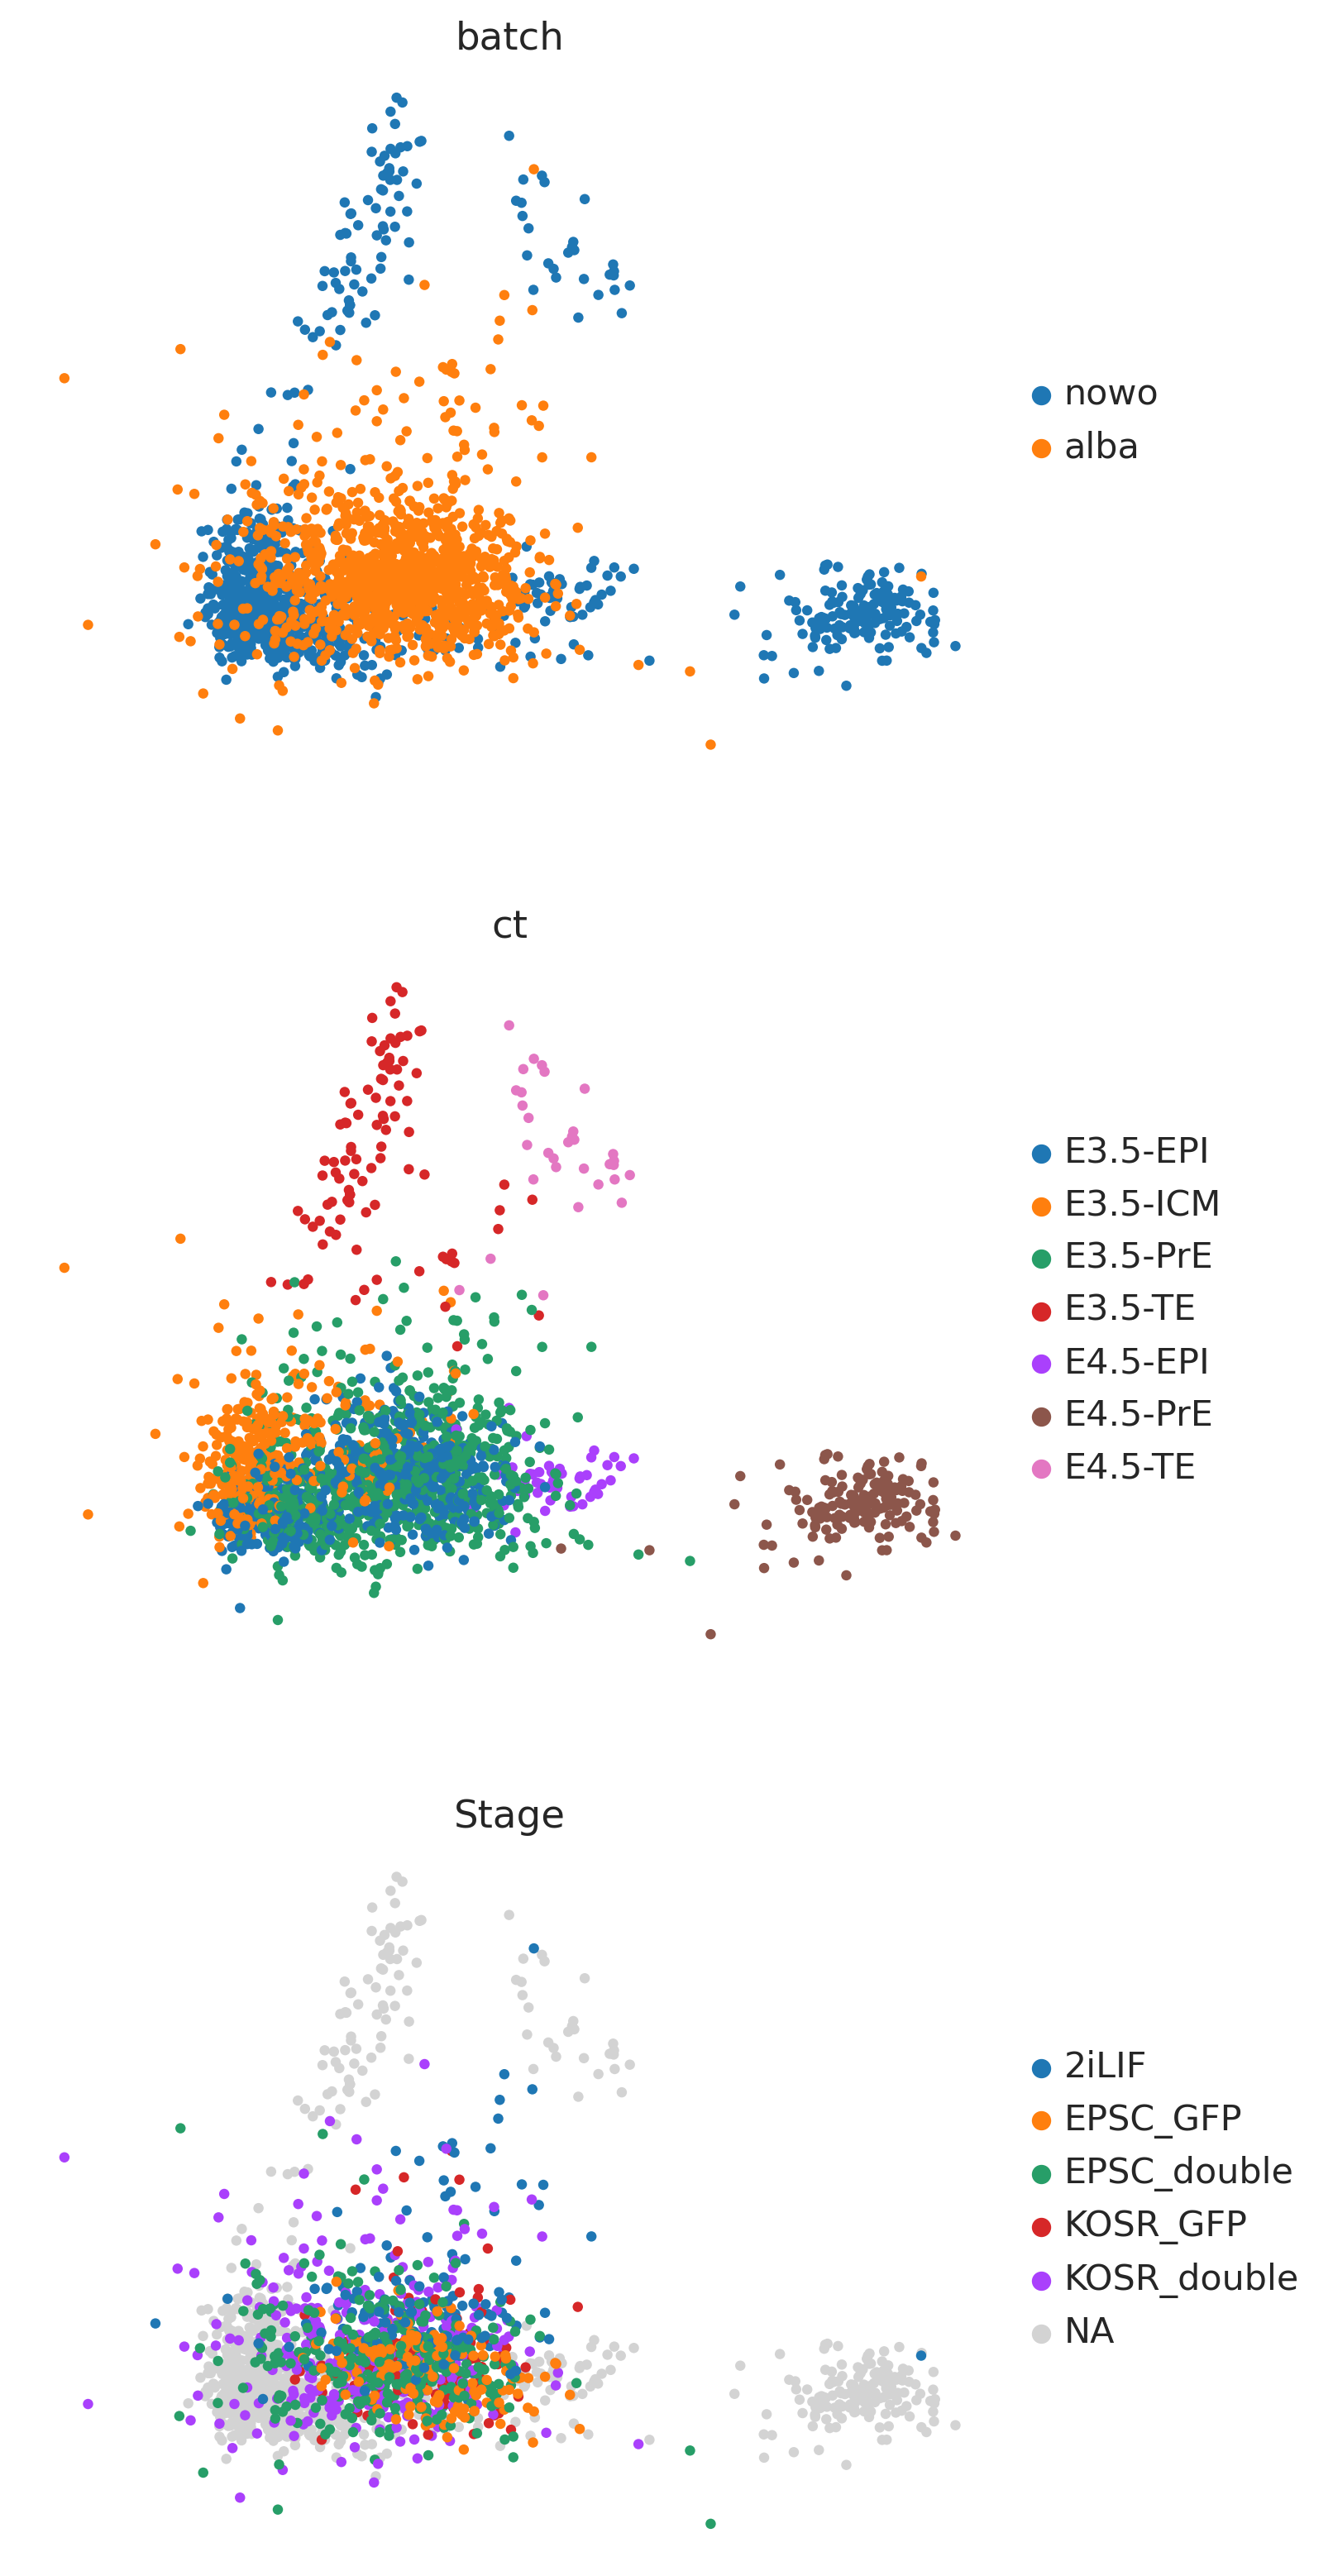

In [45]:
sc.pl.pca(adata_concat,
    color=['batch', 'ct', 'Stage'],
    frameon=False,
    ncols=1,
    save="_integration_10_PCA_integrated_withTE.svg",
)

# Analysis without TE

It appears the majority of cells map to ICM, EPI, PE labels. The follow up analysis excludes the trophectoderm (TE) populations to allow for greater resolution.

Load in the Nowotschin et al. dataset, but this time, exclude cells labelled as TE

In [46]:
nowo = sc.read("../data/external/Nowotschin_et_al_2019/sc_endoderm_all_cells.h5ad")
meta = pd.read_csv("../data/external/Nowotschin_et_al_2019/e35_cell_types.csv", index_col=0)
nowo.obs.loc[meta.index, 'CellType'] = meta.CellType
nowo = nowo[
    nowo.obs.Timepoint.isin(['E3.5', 'E4.5']) & nowo.obs.CellType.isin(['EPI','ICM','PrE'])
].copy()
nowo.obs['batch'] = "NOWO_1"
nowo.obs['experiment'] = "Nowotschin et al., 2019"
nowo.obs['technology'] = "10X 3' v2"
nowo.obs['ct'] = nowo.obs[['Timepoint', 'CellType']].agg('-'.join, axis=1)
nowo.obs['ct_orig'] = nowo.obs.CellType
nowo.obs = nowo.obs[['batch', 'experiment', 'technology', 'ct', 'ct_orig']]
nowo.var_names = nowo.var_names.str.lower()

sc.pp.filter_cells(nowo, min_counts=10)
sc.pp.filter_cells(nowo, min_genes=10)

nowo.layers["counts"] = nowo.X.copy()

sc.pp.normalize_total(nowo, target_sum=10_000)
sc.pp.log1p(nowo)
nowo.raw = nowo

In [47]:
sc.pp.highly_variable_genes(
    nowo,
    flavor="seurat_v3",
    n_top_genes=1_000,
    layer="counts",
    batch_key="batch",
    min_mean=0.0125, max_mean=10, min_disp=0.5,
    subset=True,
)

sc.pp.pca(nowo)
sc.pp.neighbors(nowo)
sc.tl.umap(nowo)

In [48]:
nowo = nowo[:, nowo.var.highly_variable].copy()
sc.pp.scale(nowo, max_value=10)

## Load in experimental single cell RNA-seq data

In [49]:
alba_adata = sc.read('../data/processed/10_dataset_v2.h5ad')

In [50]:
alba_adata

AnnData object with n_obs × n_vars = 1139 × 21590
    obs: 'Well_ID', 'Well_coordinates', 'plate_ID', 'Subject_ID', 'Amp_batch_ID', 'Cell_barcode', 'Pool_barcode', 'Batch', 'Condition', 'SampleName', 'Stage', 'Source', 'SubGroup', 'Group', 'Clone', 'All.Events.GFP-A.Geo.Mean', 'All.Events.561D-A.Geo.Mean', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts', 'leiden', 'S_score', 'G2M_score', 'phase', 'S2G6+'
    var: 'gene_ids', 'feature_types', 'mt', 'ercc', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'Amp_batch_ID_colors', 'S2G6+_colors', 'Stage_colors', 'dendrogram_Stage', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'plate_ID_colors', 'rank_genes_gr

### Map experimental data onto filtered atlas

In [51]:
nowo.var_names = nowo.var_names.str.upper()
alba_adata.var_names = alba_adata.var_names.str.upper()
var_names = nowo.var_names.intersection(alba_adata.var_names)
nowo = nowo[:, var_names].copy()
alba_adata = alba_adata[:, var_names].copy()

In [52]:
sc.tl.ingest(alba_adata, nowo, obs = 'ct')

In [53]:
adata_concat = nowo.concatenate(alba_adata, batch_categories=['nowo', 'alba'])

In [54]:
adata_concat

AnnData object with n_obs × n_vars = 2041 × 917
    obs: 'batch', 'experiment', 'technology', 'ct', 'ct_orig', 'n_counts', 'n_genes', 'Well_ID', 'Well_coordinates', 'plate_ID', 'Subject_ID', 'Amp_batch_ID', 'Cell_barcode', 'Pool_barcode', 'Batch', 'Condition', 'SampleName', 'Stage', 'Source', 'SubGroup', 'Group', 'Clone', 'All.Events.GFP-A.Geo.Mean', 'All.Events.561D-A.Geo.Mean', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', 'total_counts_ribo', 'pct_counts_ribo', 'leiden', 'S_score', 'G2M_score', 'phase', 'S2G6+'
    var: 'highly_variable-alba', 'means-alba', 'highly_variable_nbatches-alba', 'mean-alba', 'std-alba', 'gene_ids-alba', 'feature_types-alba', 'mt-alba', 'ercc-alba', 'ribo-alba', 'n_cells_by_counts-alba', 'mean_counts-alba', 'pct_dropout_by_counts-alba', 'total_counts-alba', 'n_cells-alba', 'dispersions-alba', 'dispersions_norm-alba', 'highly_variable_intersection-alba', 'highly_variable-nowo', 'highly_varia

In [55]:
alba_annotated = adata_concat[adata_concat.obs.batch == 'alba']

In [56]:
alba_annotated

View of AnnData object with n_obs × n_vars = 1139 × 917
    obs: 'batch', 'experiment', 'technology', 'ct', 'ct_orig', 'n_counts', 'n_genes', 'Well_ID', 'Well_coordinates', 'plate_ID', 'Subject_ID', 'Amp_batch_ID', 'Cell_barcode', 'Pool_barcode', 'Batch', 'Condition', 'SampleName', 'Stage', 'Source', 'SubGroup', 'Group', 'Clone', 'All.Events.GFP-A.Geo.Mean', 'All.Events.561D-A.Geo.Mean', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', 'total_counts_ribo', 'pct_counts_ribo', 'leiden', 'S_score', 'G2M_score', 'phase', 'S2G6+'
    var: 'highly_variable-alba', 'means-alba', 'highly_variable_nbatches-alba', 'mean-alba', 'std-alba', 'gene_ids-alba', 'feature_types-alba', 'mt-alba', 'ercc-alba', 'ribo-alba', 'n_cells_by_counts-alba', 'mean_counts-alba', 'pct_dropout_by_counts-alba', 'total_counts-alba', 'n_cells-alba', 'dispersions-alba', 'dispersions_norm-alba', 'highly_variable_intersection-alba', 'highly_variable-nowo', 'high

In [57]:
pd.crosstab(alba_annotated.obs.Stage, alba_annotated.obs.ct)

ct           E3.5-EPI  E3.5-ICM  E3.5-PrE  E4.5-EPI  E4.5-PrE
Stage                                                        
2iLIF              93        12        54         3         1
EPSC_GFP           87         7        47         0         1
EPSC_double        89        48       189         0         1
KOSR_GFP           64         4        65         4         0
KOSR_double        75        46       248         1         0

In [58]:
alba_annotated.obs.Stage.value_counts()

KOSR_double    370
EPSC_double    327
2iLIF          163
EPSC_GFP       142
KOSR_GFP       137
Name: Stage, dtype: int64

In [59]:
alba_annotated_df=pd.DataFrame({
    'condition':alba_annotated.obs.Stage,
    'annotation':alba_annotated.obs.ct,
})

In [60]:
proportions_df = pd.crosstab(alba_annotated.obs.Stage,alba_annotated.obs.ct, normalize='index')

In [61]:
proportions_df_notNorm = pd.crosstab(alba_annotated.obs.Stage,alba_annotated.obs.ct)

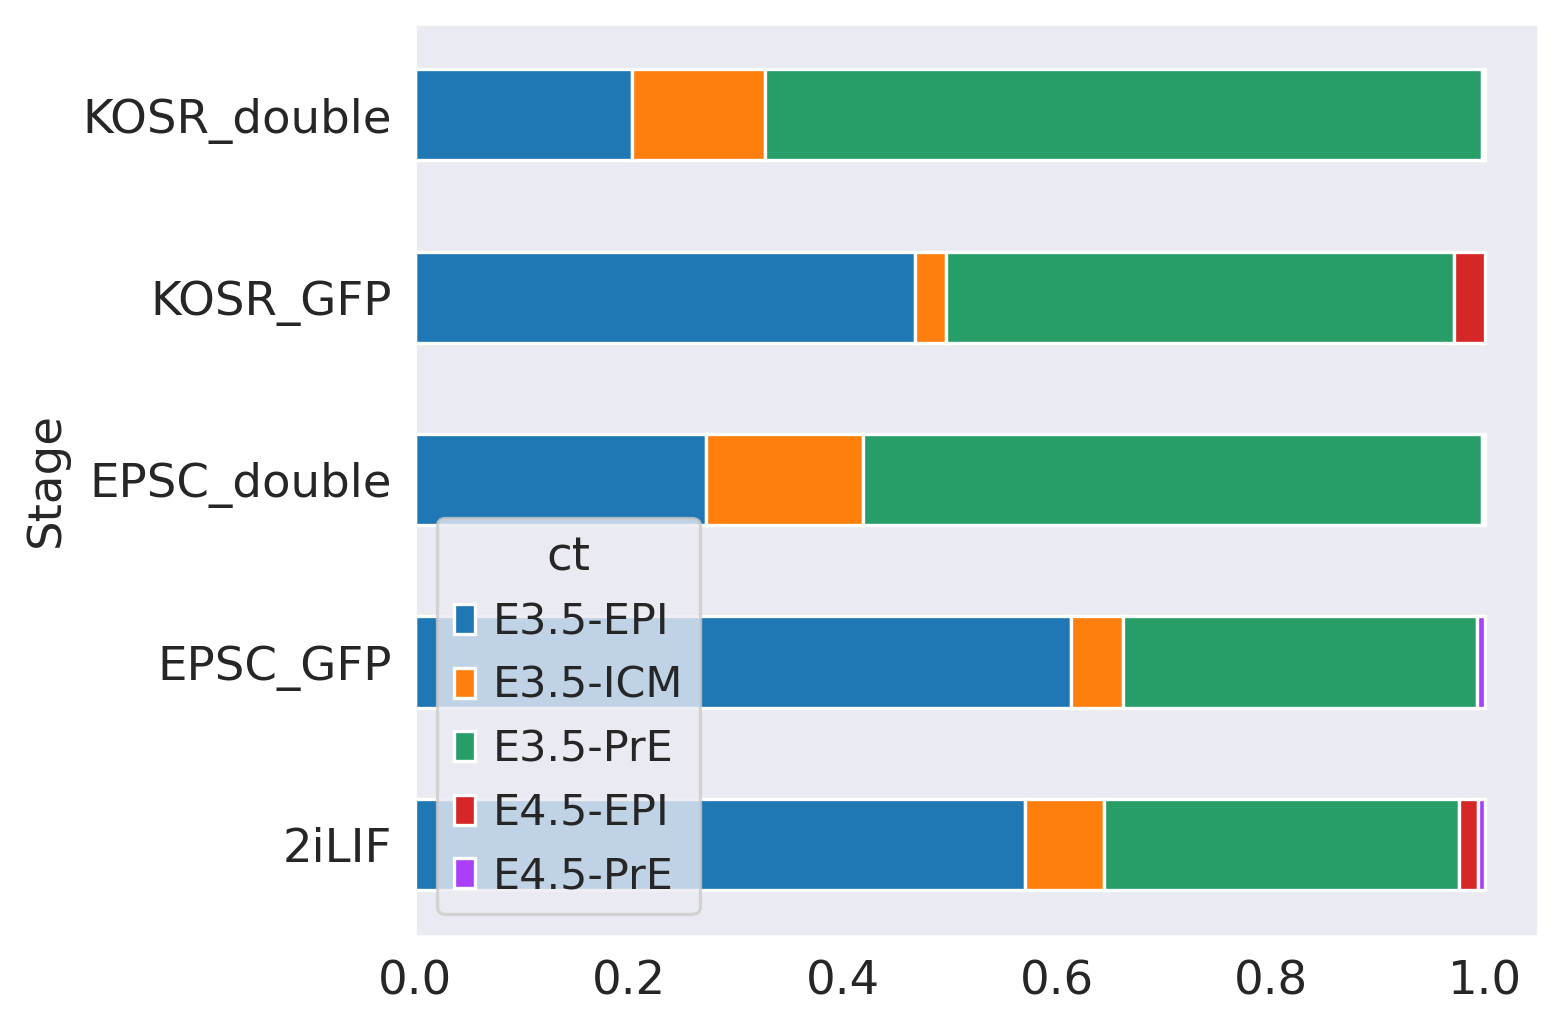

In [62]:
ax = proportions_df.plot.barh(
    stacked=True,
    grid=False,
    )
fig = ax.get_figure()
fig.savefig(f'{sc.settings.figdir}/integration_11_CellProportions_Integrated_without-TE.svg')

In [63]:
proportions_of_clusters_df = pd.crosstab(alba_annotated.obs.leiden, alba_annotated.obs.ct, normalize='index')
proportions_of_clusters_df_notNorm = pd.crosstab(alba_annotated.obs.leiden, alba_annotated.obs.ct)

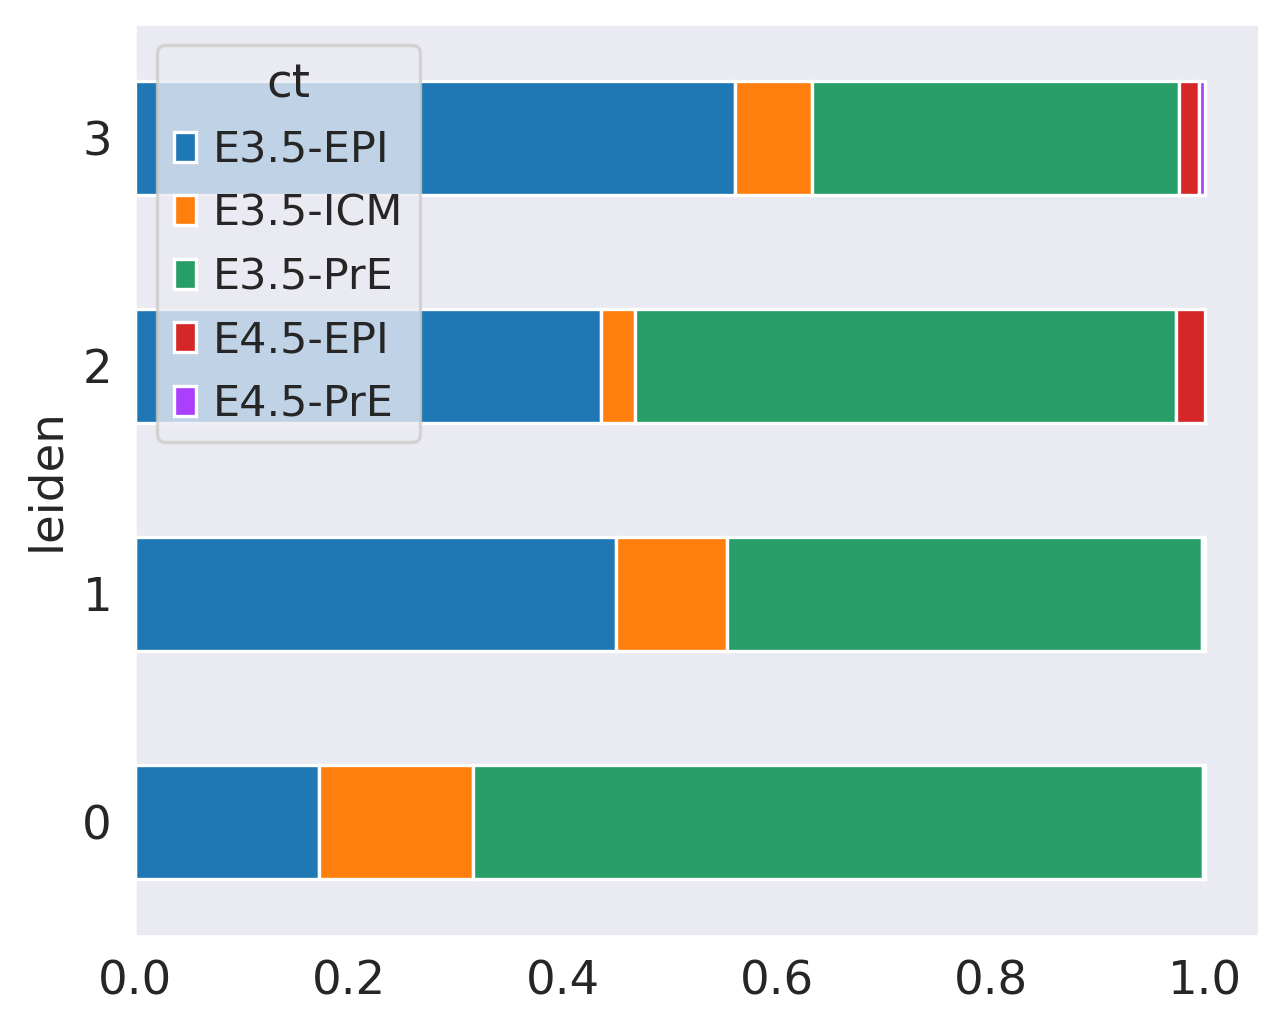

In [64]:
ax = proportions_of_clusters_df.plot.barh(
    stacked=True,
    grid=False,
    )
fig = ax.get_figure()
fig.savefig(f'{sc.settings.figdir}/integration_12_CellProportionsLeidenClusters_Integrated_without-TE.svg')

## Contingency table analysis

In [65]:
import scipy.stats as stats

In [66]:
stats.chi2_contingency(proportions_df_notNorm)

Chi2ContingencyResult(statistic=161.6138042752549, pvalue=3.931212702862735e-26, dof=16, expected_freq=array([[ 58.3880597 ,  16.74363477,  86.29411765,   1.14486392,
          0.42932397],
       [ 50.86567164,  14.58647937,  75.17647059,   0.99736611,
          0.37401229],
       [117.13432836,  33.58999122, 173.11764706,   2.29675154,
          0.86128183],
       [ 49.07462687,  14.07287094,  72.52941176,   0.96224759,
          0.36084284],
       [132.53731343,  38.00702371, 195.88235294,   2.59877085,
          0.97453907]]))

In [67]:
alba_chi2 = stats.chi2_contingency(proportions_df_notNorm)

In [68]:
alba_chi2.pvalue

3.931212702862735e-26

In [69]:
alba_chi2.statistic

161.6138042752549

In [70]:
# https://stackoverflow.com/questions/20453729/what-is-the-equivalent-of-r-data-chisqresiduals-in-python
from scipy.stats.contingency import margins

def residuals(observed, expected):
    return (observed - expected) / np.sqrt(expected)

def stdres(observed, expected):
    n = observed.sum()
    rsum, csum = margins(observed)
    # With integers, the calculation
    #     csum * rsum * (n - rsum) * (n - csum)
    # might overflow, so convert rsum and csum to floating point.
    rsum = rsum.astype(np.float64)
    csum = csum.astype(np.float64)
    v = csum * rsum * (n - rsum) * (n - csum) / n**3
    return (observed - expected) / np.sqrt(v)

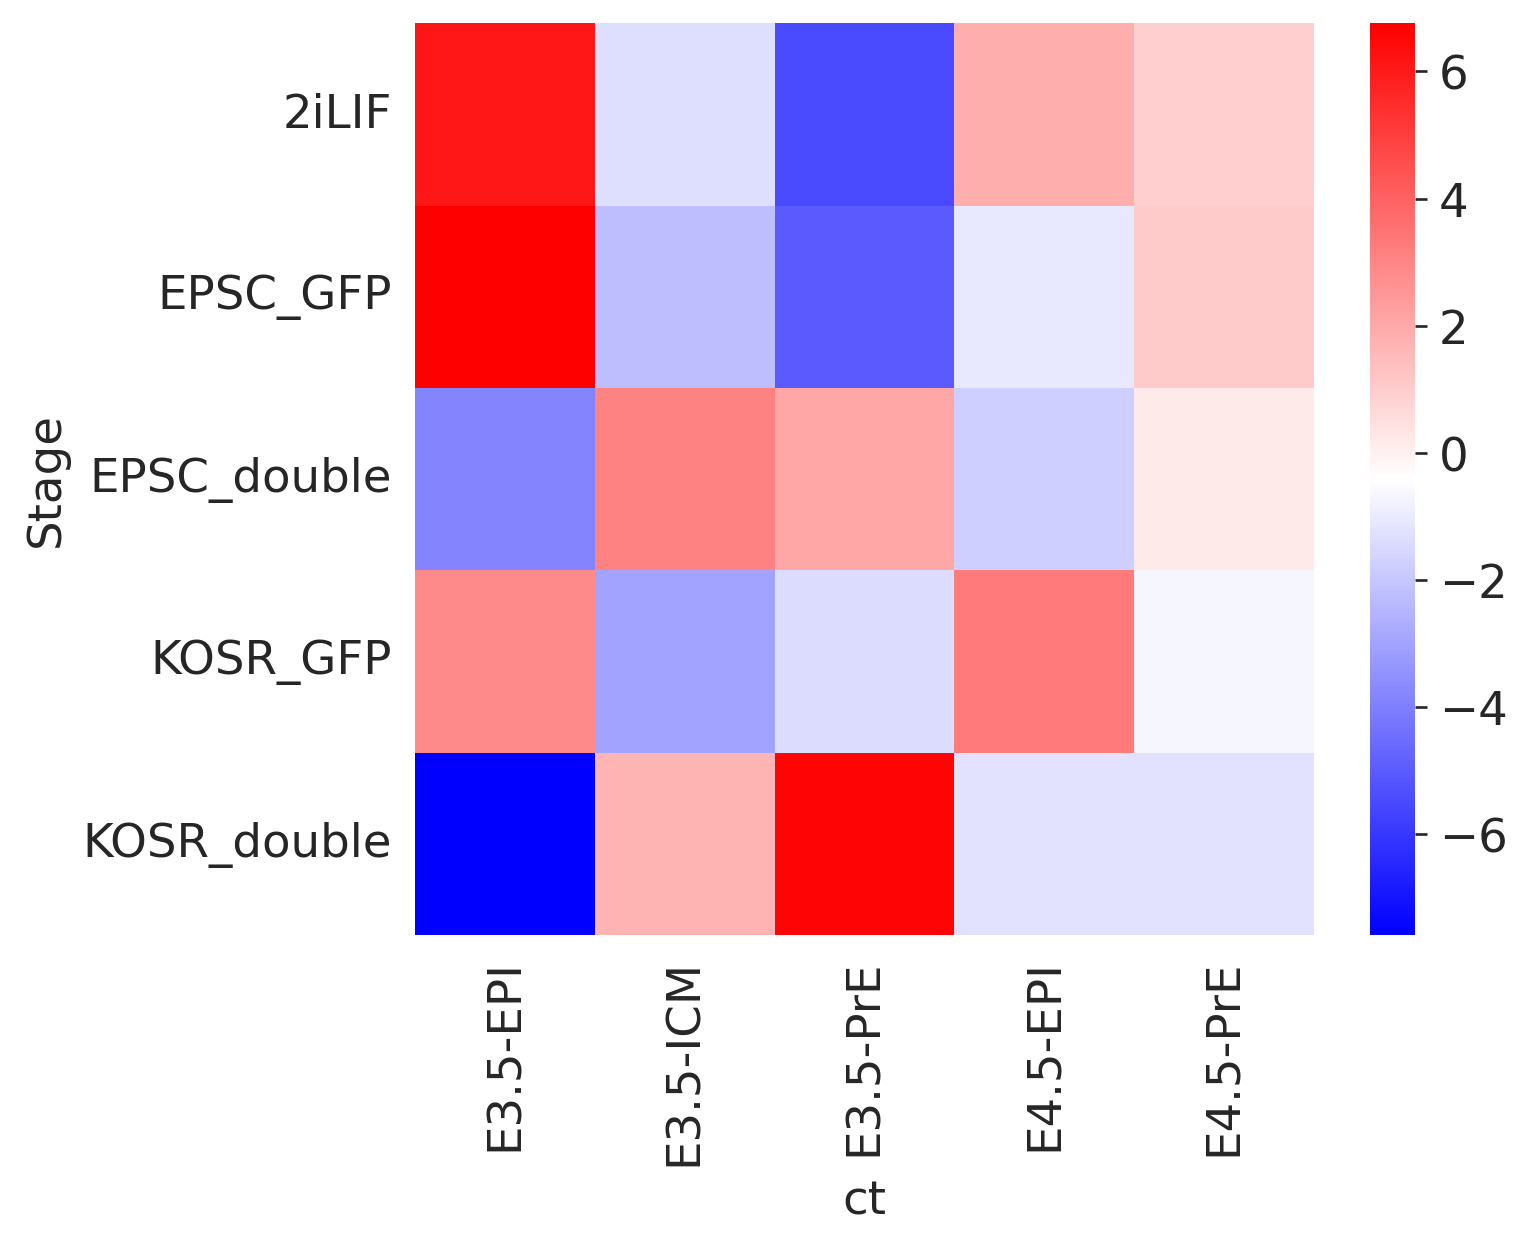

In [71]:
ax = sns.heatmap(
    pd.DataFrame(stdres(proportions_df_notNorm.to_numpy(), alba_chi2.expected_freq), columns= proportions_df_notNorm.columns, index=proportions_df_notNorm.index),
    cmap='bwr'
)
fig = ax.get_figure()
fig.savefig(f'{sc.settings.figdir}/integration_13_ChiSquared_NormalisedResiduals-withoutTE.svg')

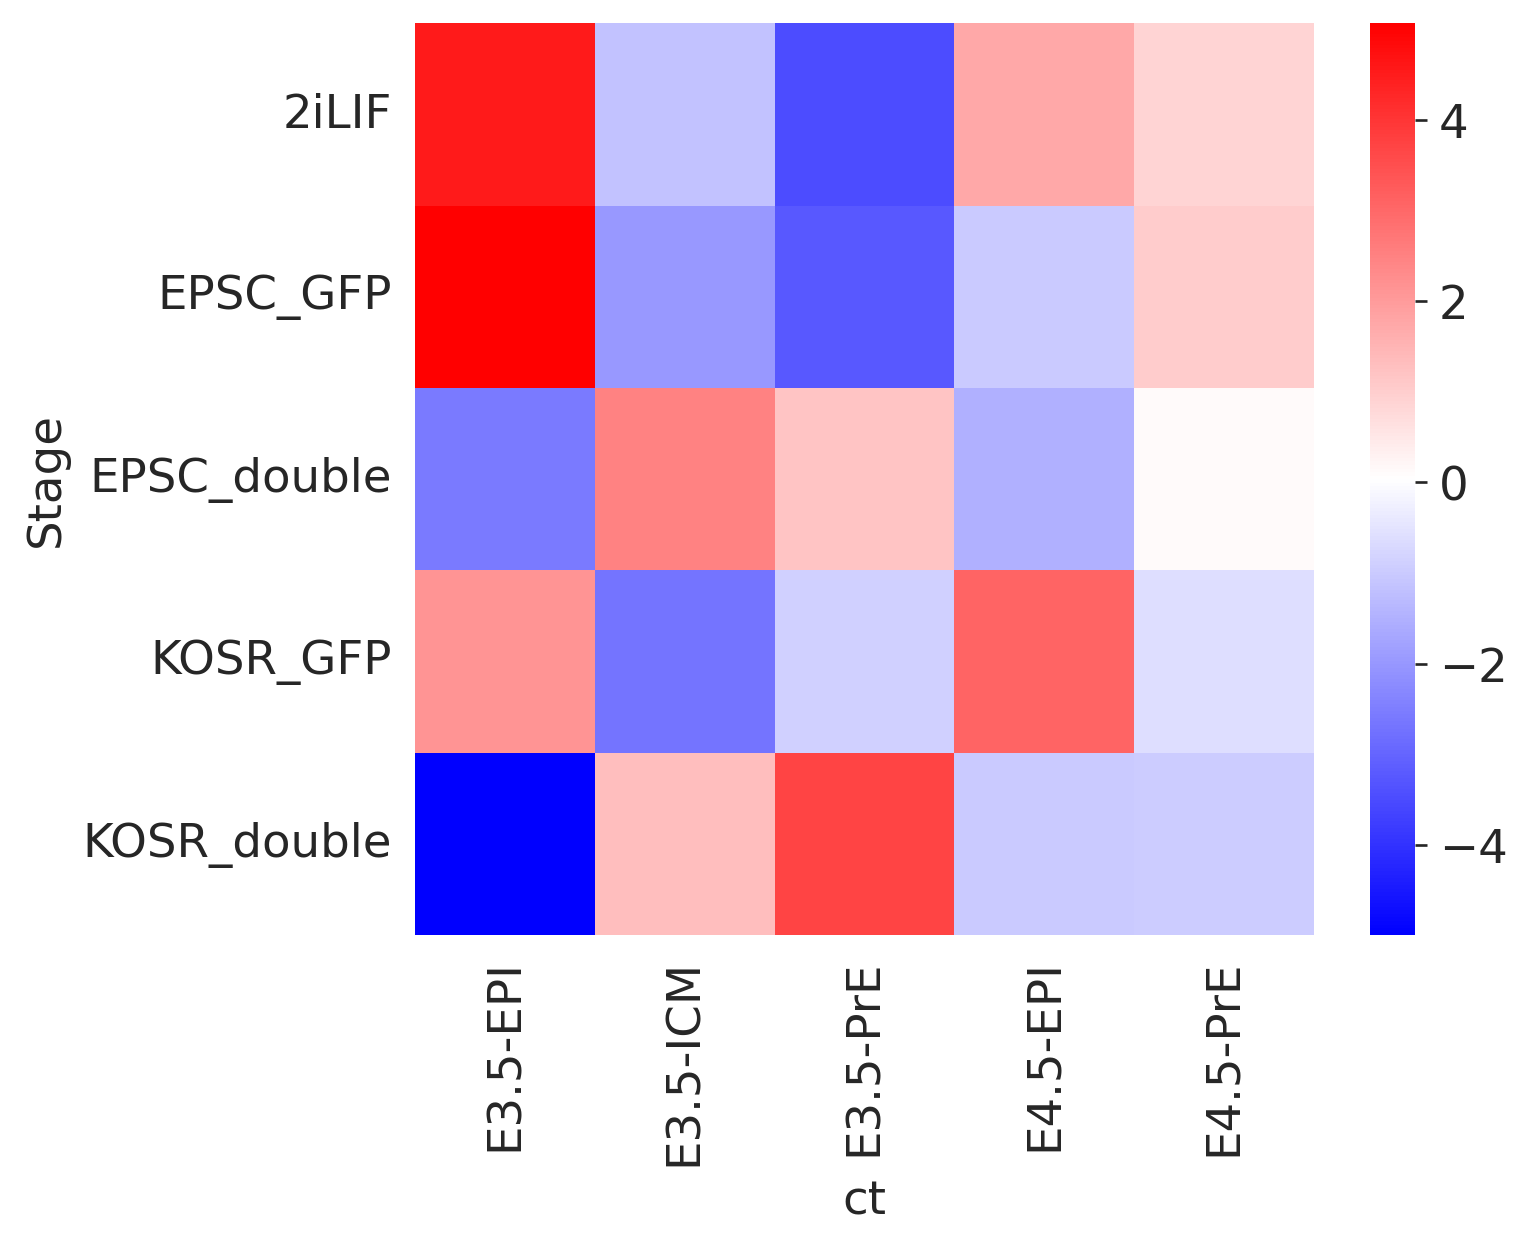

In [72]:
ax = sns.heatmap(
    pd.DataFrame(residuals(proportions_df_notNorm.to_numpy(), alba_chi2.expected_freq), columns= proportions_df_notNorm.columns, index=proportions_df_notNorm.index),
    cmap='bwr'
)
fig = ax.get_figure()
fig.savefig(f'{sc.settings.figdir}/integration_14_ChiSquared_RawResiduals-withoutTE.svg')

### Significance tests using clusters

In [73]:
stats.chi2_contingency(proportions_of_clusters_df_notNorm)

Chi2ContingencyResult(statistic=144.80555129331256, pvalue=6.398572999546904e-25, dof=12, expected_freq=array([[154.3880597 ,  44.27304653, 228.17647059,   3.02721686,
          1.13520632],
       [128.23880597,  36.77436348, 189.52941176,   2.51448639,
          0.9429324 ],
       [ 65.91044776,  18.90079017,  97.41176471,   1.29236172,
          0.48463565],
       [ 59.46268657,  17.05179982,  87.88235294,   1.16593503,
          0.43722564]]))

In [74]:
seurat_clusters_chi2 = stats.chi2_contingency(proportions_of_clusters_df_notNorm)

In [75]:
seurat_clusters_chi2.pvalue

6.398572999546904e-25

In [76]:
seurat_clusters_chi2.statistic

144.80555129331256

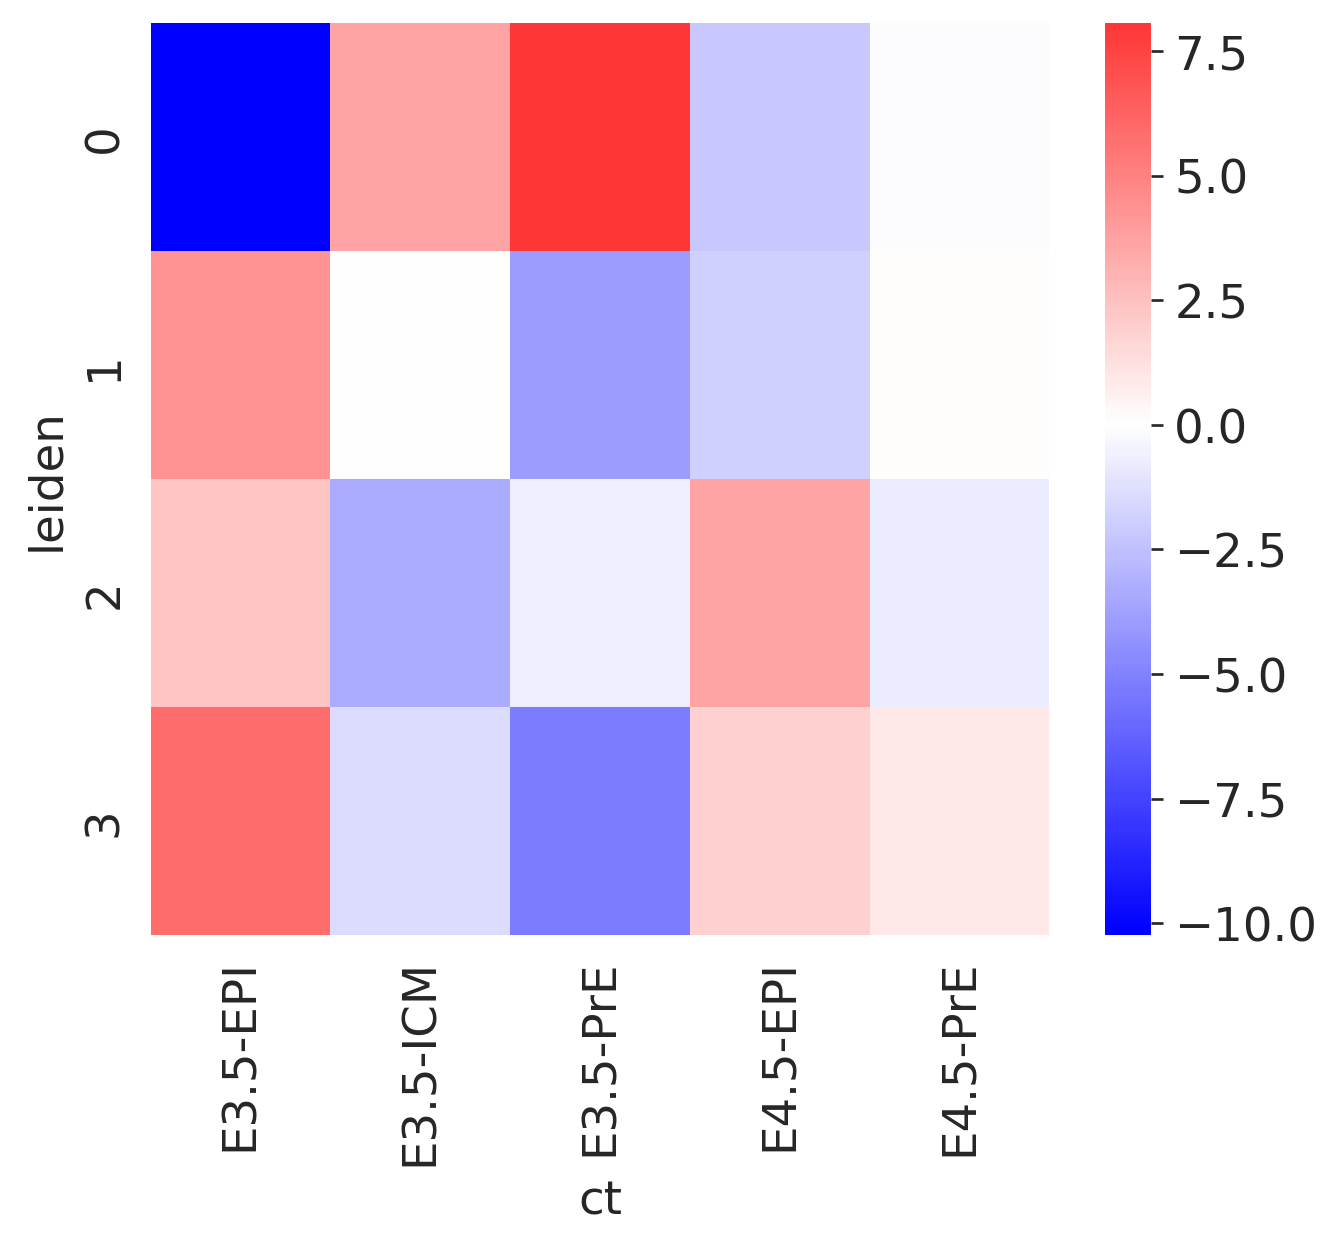

In [77]:
ax = sns.heatmap(
    pd.DataFrame(stdres(proportions_of_clusters_df_notNorm.to_numpy(), seurat_clusters_chi2.expected_freq), columns= proportions_of_clusters_df_notNorm.columns, index=proportions_of_clusters_df_notNorm.index),
    cmap='bwr', center = 0.0
)
fig = ax.get_figure()
fig.savefig(f'{sc.settings.figdir}/integration_15_LeidenClusters_ChiSquared_NormalisedResiduals-withoutTE.svg')

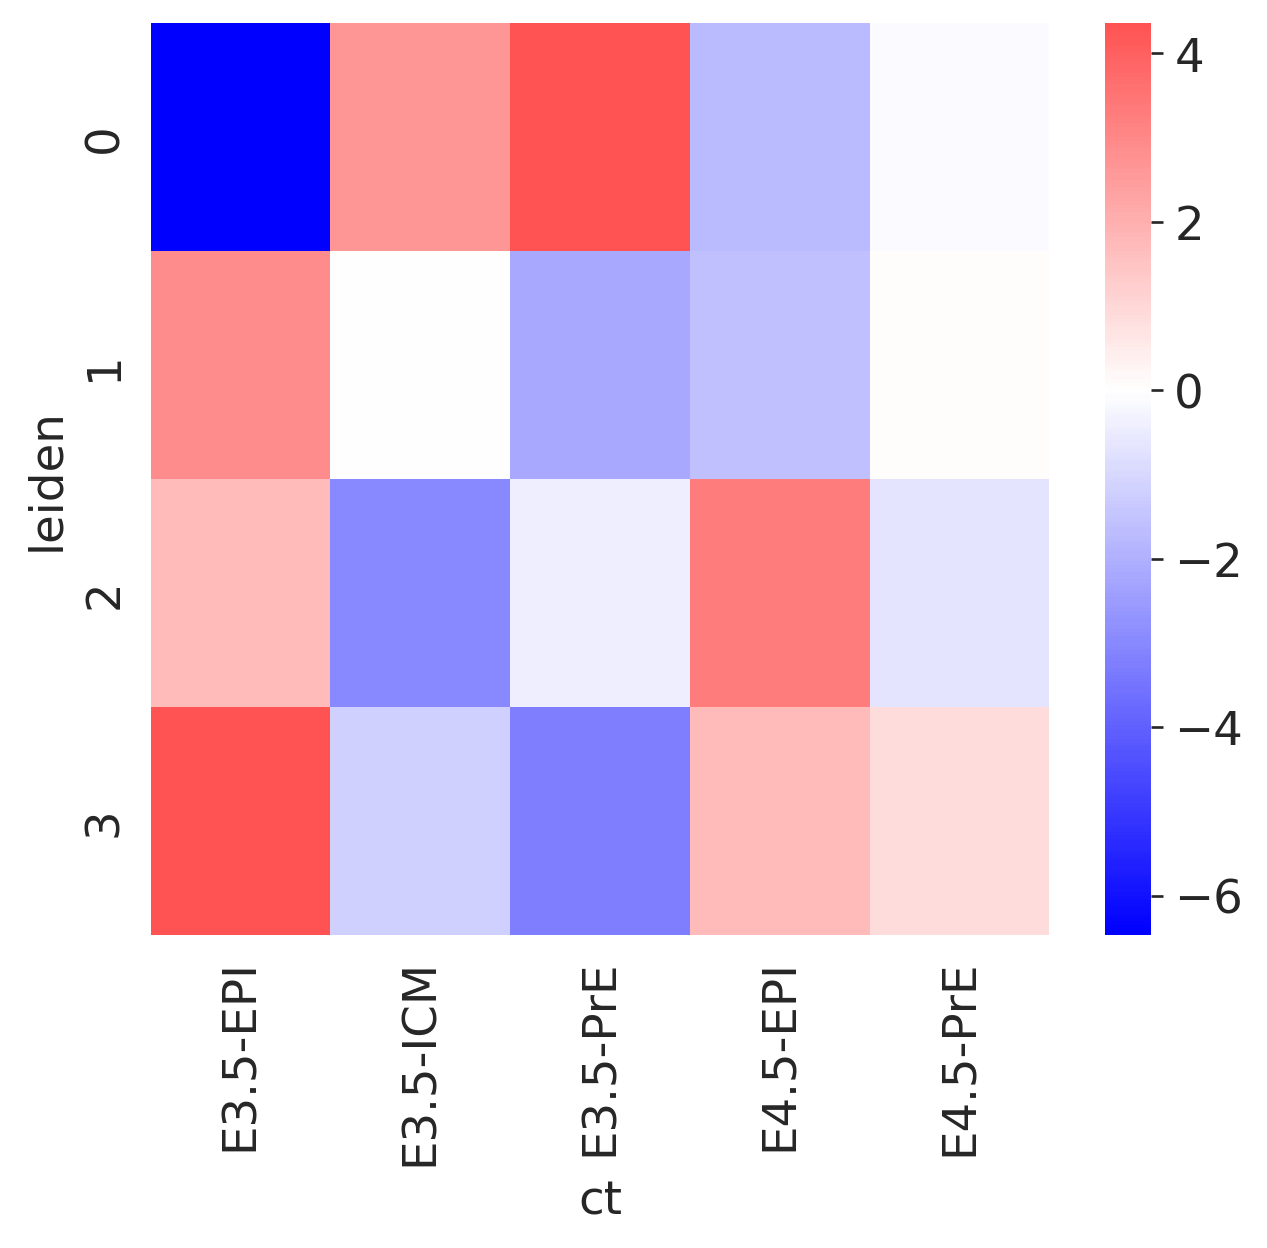

In [78]:
ax = sns.heatmap(
    pd.DataFrame(residuals(proportions_of_clusters_df_notNorm.to_numpy(), seurat_clusters_chi2.expected_freq), columns= proportions_of_clusters_df_notNorm.columns, index=proportions_of_clusters_df_notNorm.index),
    cmap='bwr', center = 0.0
)
fig = ax.get_figure()
fig.savefig(f'{sc.settings.figdir}/integration_16_LeidenClusters_ChiSquared_RawResiduals-withoutTE.svg')

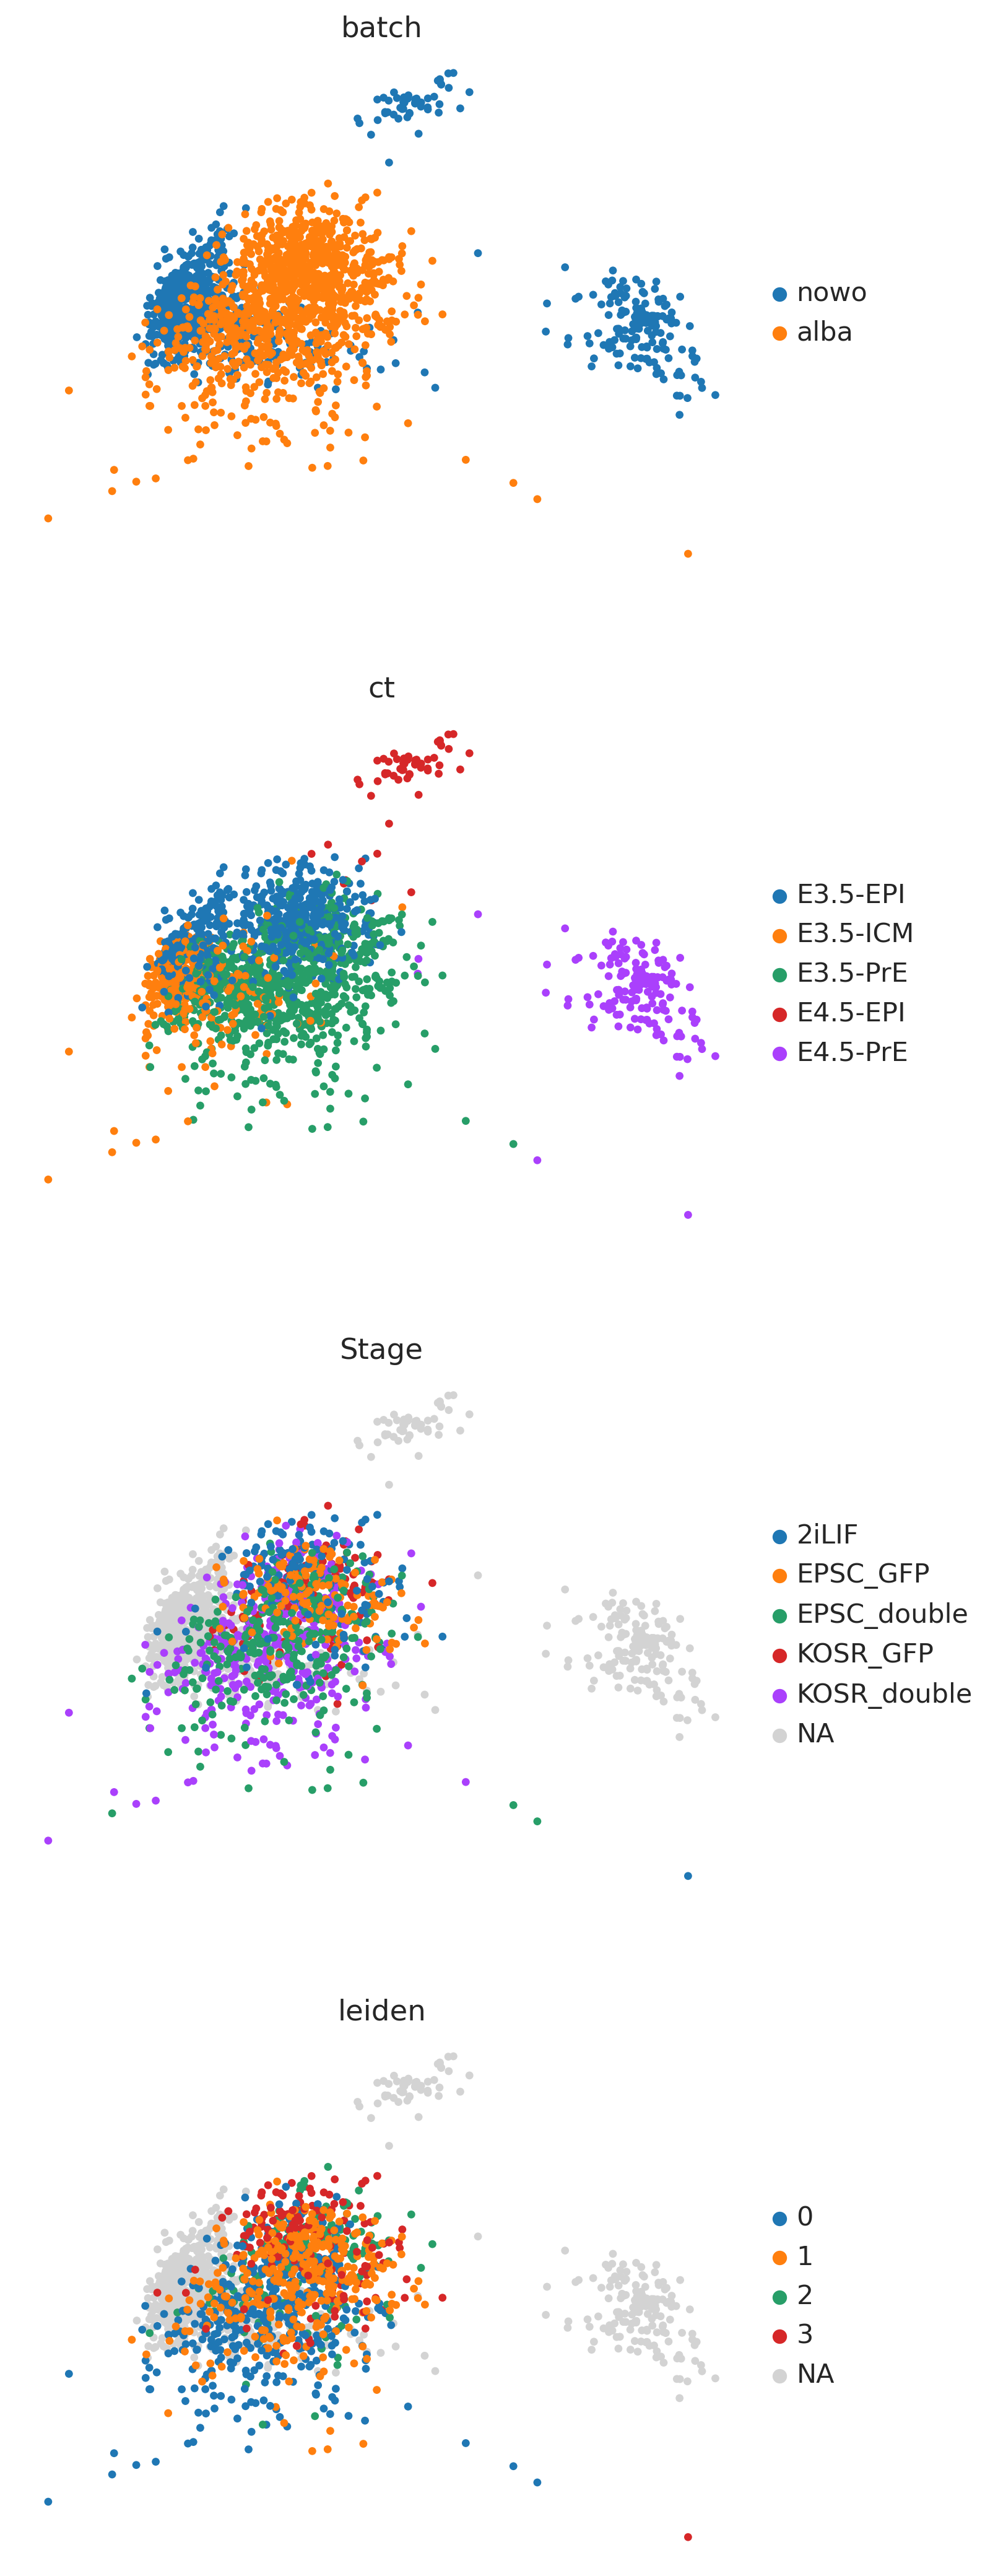

In [79]:
sc.pl.pca(adata_concat,
    color=['batch', 'ct', 'Stage', 'leiden'],
    frameon=False,
    ncols=1,)

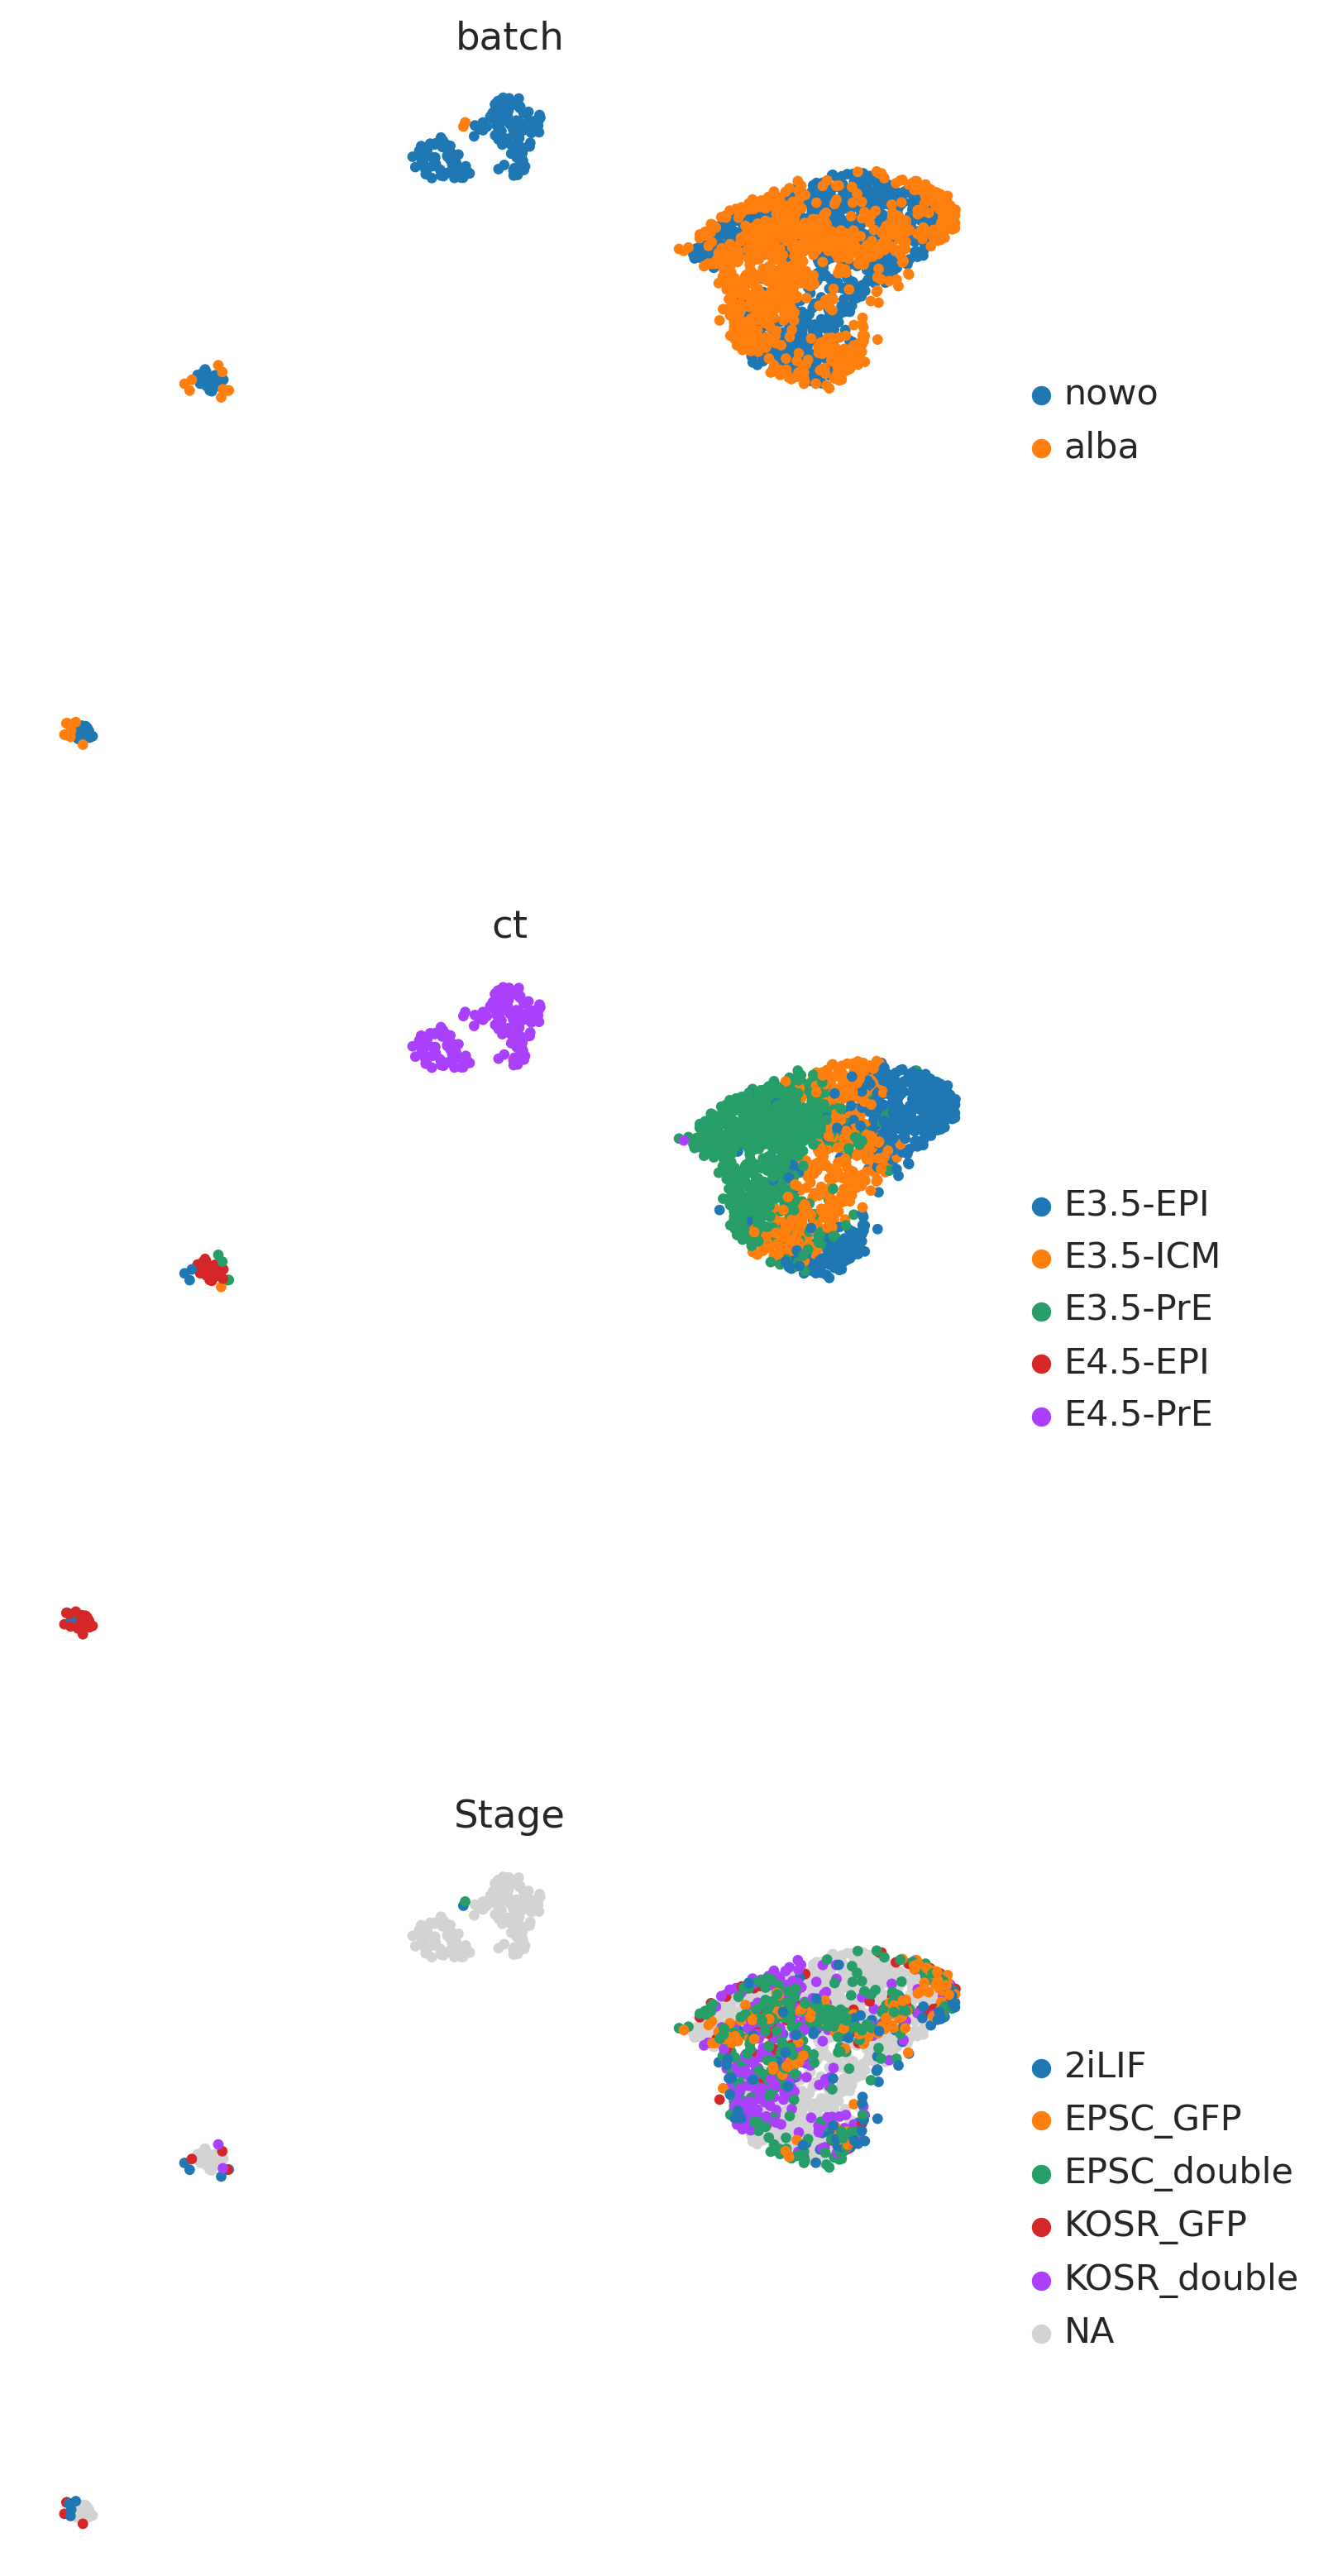

In [80]:
sc.pl.umap(adata_concat,
    color=['batch', 'ct', 'Stage'],
    ncols = 1,
    frameon=False,
    save="_integration_17_UMAP_integrated_withoutTE.svg",
 )

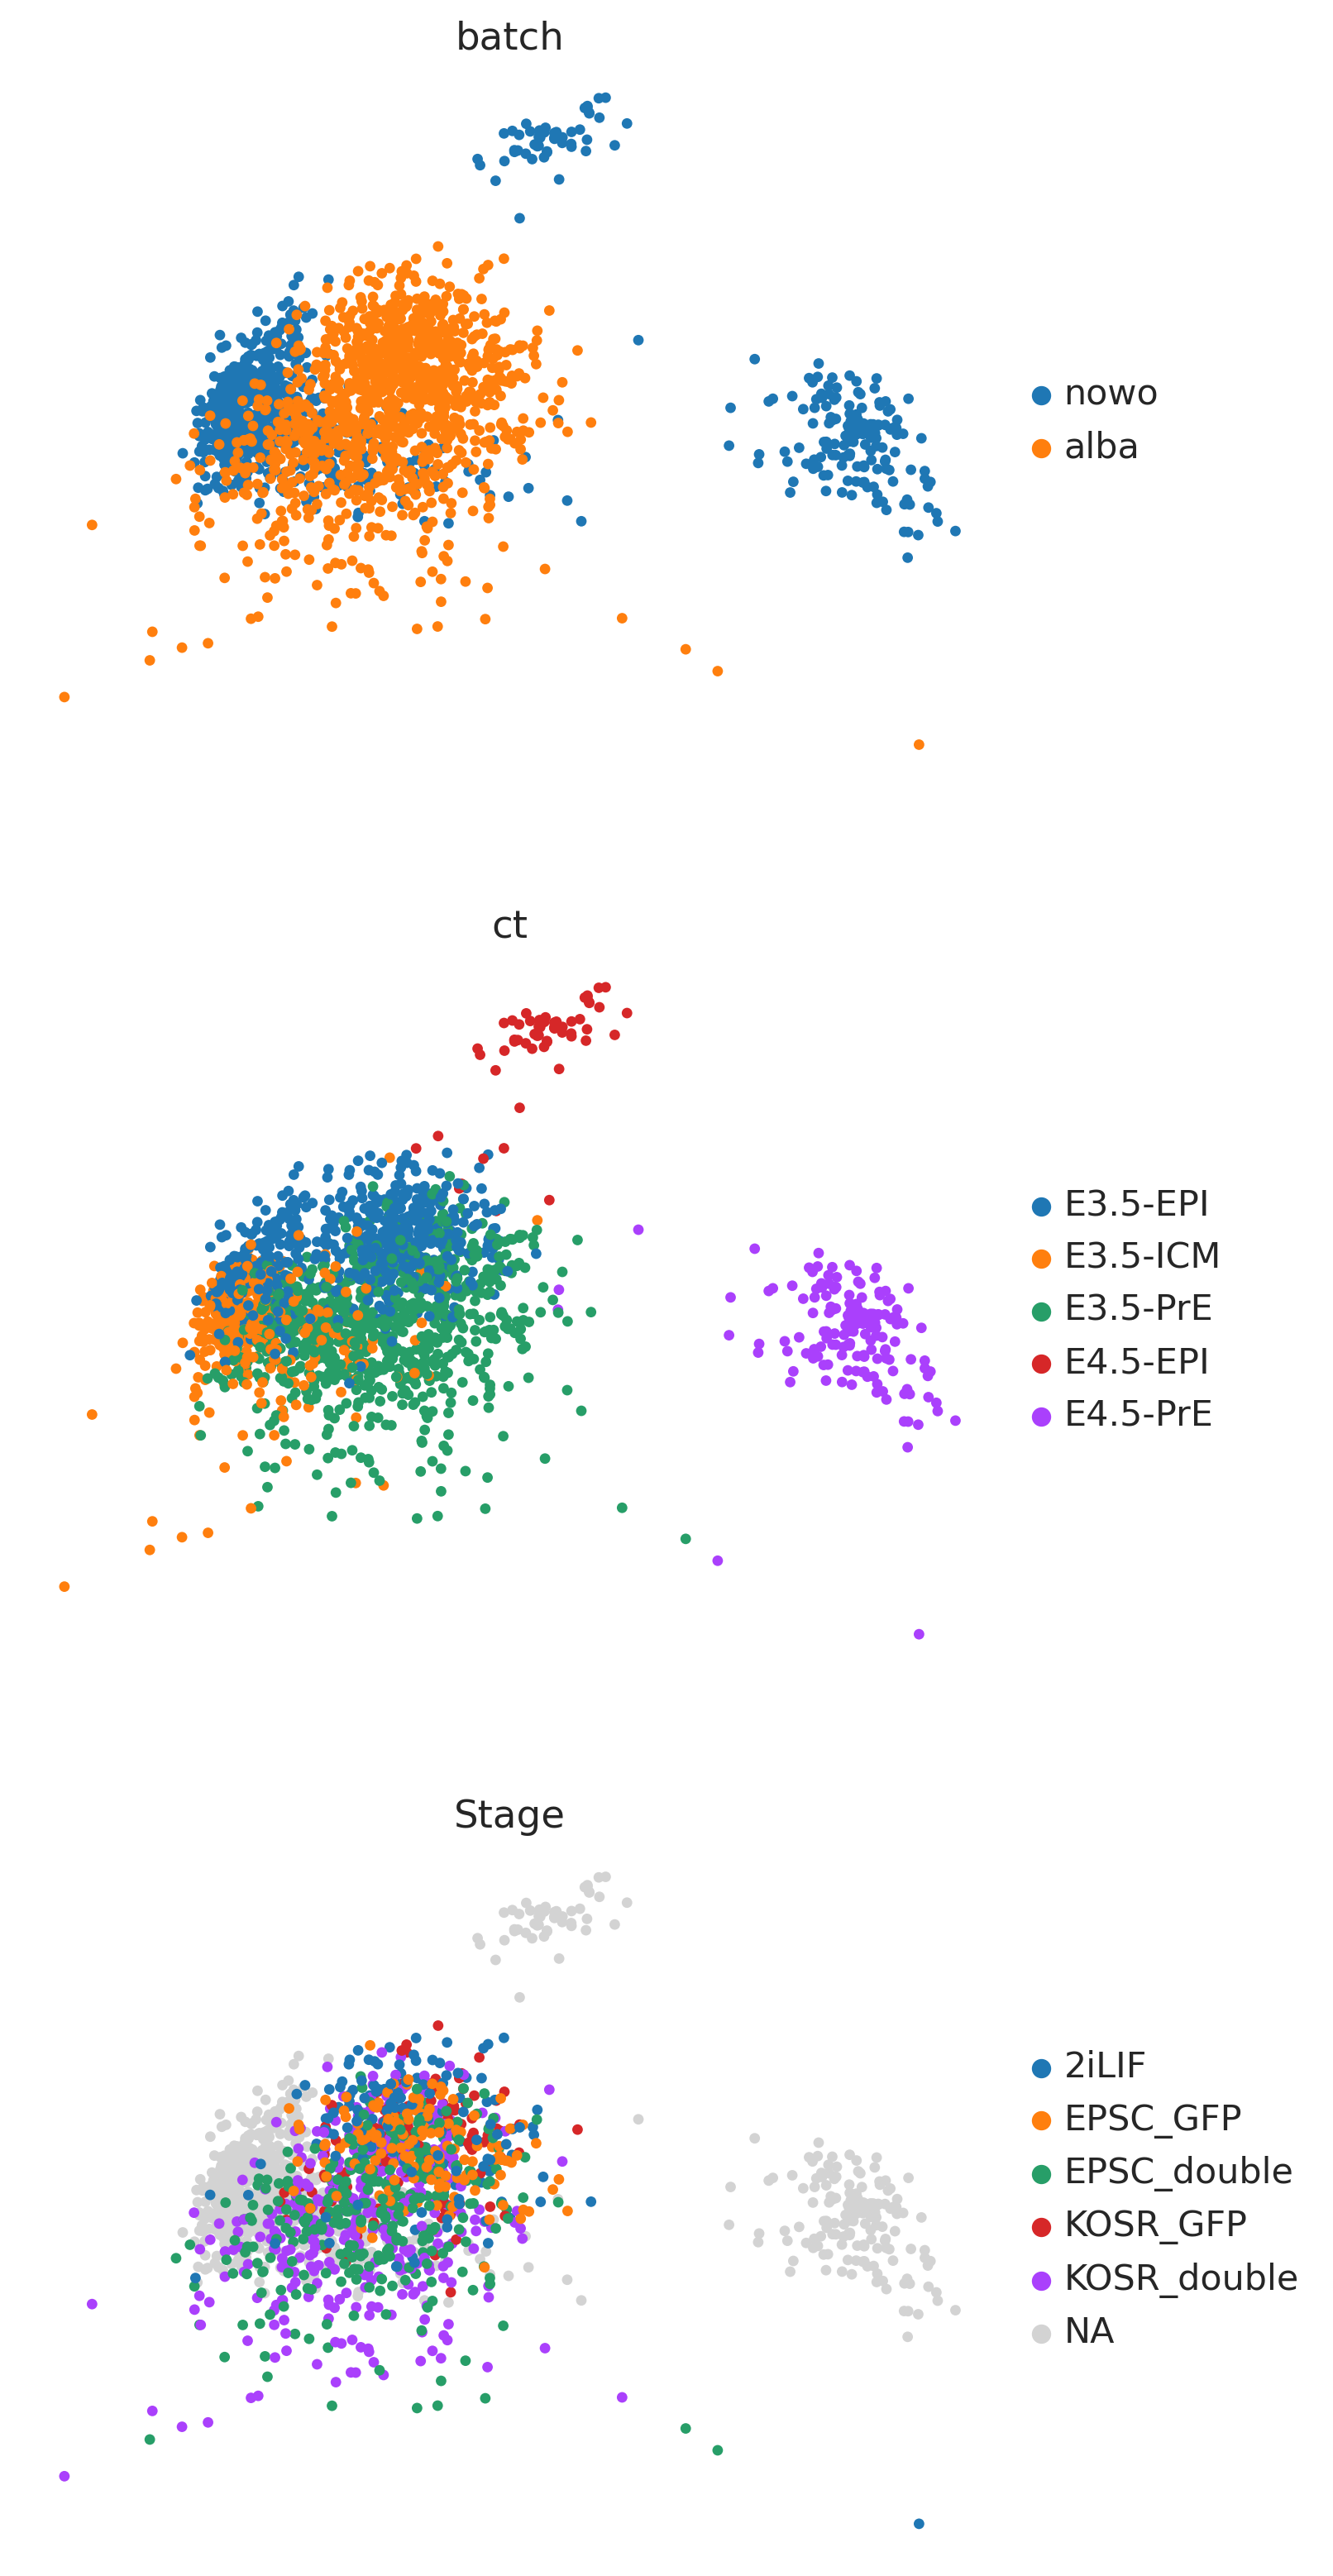

In [81]:
sc.pl.pca(adata_concat,
    color=['batch', 'ct', 'Stage'],
    frameon=False,
    ncols=1,
    save="_integration_18_PCA_integrated_withoutTE.svg",
)

# Session information

In [82]:
import session_info
session_info.show()